In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, f_oneway
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# -----------------------------
# 1. Data Preprocessing Function
# -----------------------------
def preprocess_data(data_path):
    df = pd.read_csv(data_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    

    # Remove columns and rows that are completely NA or 0
    df = df.loc[:, ~((df.isna()) | (df == 0)).all()]
    df = df.loc[~((df.isna()) | (df == 0)).all(axis=1)]

    # Temporal features
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['month'] = df['Timestamp'].dt.month

    # Seasonal/diurnal weight mappings (optional use)
    month_weights = {1: 1.0, 2: 0.8, 3: 0.6, 4: 0.4, 5: 0.2, 6: 0.1,
                     7: 0.1, 8: 0.1, 9: 0.2, 10: 0.6, 11: 0.9, 12: 1.0}
    hour_weights = {i: 0.9 - abs(12 - i) * 0.05 for i in range(24)}

    df['PM2.5_month_weight'] = df['month'].map(month_weights)
    df['PM2.5_hour_weight'] = df['hour'].map(hour_weights)

    # Interpolation and resampling
    df.interpolate(method='linear', limit_direction='both', inplace=True)
    df.set_index('Timestamp', inplace=True)
    df = df.resample('1h').mean().reset_index()

    # Outlier clipping (IQR method)
    for col in df.select_dtypes(include='number').columns:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)

    return df

In [3]:
# -----------------------------
# 2. Nearest Stations Finder
# -----------------------------
class NearestStationsFinder:
    def __init__(self, location_file):
        self.locations = pd.read_csv(location_file)
        self.locations.columns = self.locations.columns.str.strip()
        self.locations['Location'] = self.locations['Location'].str.strip()

    def find_nearest_stations(self, station_name, k=5):
        if station_name not in self.locations['Location'].values:
            raise ValueError(f"Station '{station_name}' not found in the list.")
        
        station_coords = self.locations[self.locations['Location'] == station_name][['Latitudes', 'Longitudes']].values[0]
        self.locations['Distance_km'] = self.locations.apply(
            lambda row: geodesic(station_coords, (row['Latitudes'], row['Longitudes'])).km,
            axis=1
        )
        return self.locations.sort_values(by='Distance_km').iloc[1:k + 1].copy()

    def get_all_nearest_stations(self, k=5):
        all_nearest = []
        for station in self.locations['Location']:
            try:
                nearest = self.find_nearest_stations(station, k)
                nearest['Main_Station'] = station
                all_nearest.append(nearest[['Main_Station', 'Location', 'Distance_km']])
            except ValueError as e:
                print(e)
        return pd.concat(all_nearest, ignore_index=True)

In [4]:
# -----------------------------
# 3. Distance-Based MI Analyzer
# -----------------------------
class DistanceBasedMIAnalyzer:
    def __init__(self, data_file, location_file):
        self.data = preprocess_data(data_file)  # ✅ Preprocess here
        self.data.columns = self.data.columns.str.strip()
        self.stations = list(set([col.split('_')[0] for col in self.data.columns if '_' in col]))
        self.nearest_finder = NearestStationsFinder(location_file)

    def analyze(self, k=5):
        all_results = []
        for station in self.stations:
            try:
                print(f"Processing Distance-Based MI for: {station}")
                nearest_stations = self.nearest_finder.find_nearest_stations(station, k)
                main_pm25_col = f"{station}_PM2.5 (µg/m³)"
                if main_pm25_col not in self.data.columns:
                    continue

                main_pm25_data = self.data[main_pm25_col]

                for idx, neighbor in enumerate(nearest_stations['Location']):
                    neighbor_data = pd.DataFrame()
                    for col in self.data.columns:
                        if col.startswith(f"{neighbor}_"):
                            param = col.split('_', 1)[1]
                            neighbor_data[param] = self.data[col]

                    # Exclude pollutant columns from MI calculation
                    filtered_data = neighbor_data.drop(columns=[
                        col for col in neighbor_data.columns if any(x in col for x in ['PM2.5', 'PM10', 'NO2'])
                    ], errors='ignore')

                    aligned = pd.concat([main_pm25_data, filtered_data], axis=1).dropna()
                    if aligned.shape[0] < 10:
                        continue

                    X = aligned[filtered_data.columns]
                    y = aligned[main_pm25_col]
                    mi_scores = mutual_info_regression(X, y, n_neighbors=5)
                    distance = nearest_stations.iloc[idx]['Distance_km']

                    for i, param in enumerate(X.columns):
                        all_results.append({
                            'Main_Station': station,
                            'Source_Station': neighbor,
                            'Parameter': param,
                            'MI_Score': mi_scores[i],
                            'Distance_km': distance,
                            'Weighted_MI_Score': mi_scores[i] / (distance + 1e-5)
                        })

            except ValueError as e:
                print(e)

        return pd.DataFrame(all_results)


In [5]:
# -----------------------------
# 4. Run the Full Analysis
# -----------------------------
data_file = r"C:\Users\jains\OneDrive\Desktop\coding\cleaned_dataset_pusa_avg111.cs"
location_file = r'C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\location.csv'

analyzer = DistanceBasedMIAnalyzer(data_file, location_file)
results_df = analyzer.analyze(k=5)

print(results_df.head())
results_df.to_csv('mi_calculation_based_on_distance.csv', index=False)

    # Optionally: save nearest station table
finder = NearestStationsFinder(location_file)
nearest_df = finder.get_all_nearest_stations(k=5)
nearest_df.to_csv('nearest_stations.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jains\\OneDrive\\Desktop\\coding\\cleaned_dataset_pusa_avg111.cs'

In [ ]:
import os

# Define your save directory
save_dir = r"C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\results"
os.makedirs(save_dir, exist_ok=True)

# ---------- 1. Save MI results ----------
mi_csv_path = os.path.join(save_dir, "mi_calculation_based_on_distance.csv")
results_df.to_csv(mi_csv_path, index=False)
print(f"✔️ MI results saved to: {mi_csv_path}")

# ---------- 2. Save preprocessed data ----------
# If you haven't yet preprocessed separately
preprocessed_df = preprocess_data(data_file)
preprocessed_csv_path = os.path.join(save_dir, "preprocessed_all_station_data.csv")
preprocessed_df.to_csv(preprocessed_csv_path, index=False)
print(f"✔️ Preprocessed data saved to: {preprocessed_csv_path}")


✔️ MI results saved to: C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\results\mi_calculation_based_on_distance.csv
✔️ Preprocessed data saved to: C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\results\preprocessed_all_station_data.csv


In [ ]:
preprocessed_df.shape
preprocessed_df.head()

Timestamp  Dwarka-Sector 8_PM2.5 (µg/m³)  \
0 2017-01-01 00:00:00                          178.0   
1 2017-01-01 01:00:00                          178.0   
2 2017-01-01 02:00:00                          178.0   
3 2017-01-01 03:00:00                          178.0   
4 2017-01-01 04:00:00                          178.0   

   Dwarka-Sector 8_PM10 (µg/m³)  Dwarka-Sector 8_NO2 (µg/m³)  \
0                         379.0                   124.781875   
1                         379.0                   124.781875   
2                         379.0                   124.781875   
3                         379.0                   124.781875   
4                         379.0                   124.781875   

   Dwarka-Sector 8_AT (°C)  Dwarka-Sector 8_RH (%)  Dwarka-Sector 8_WS (m/s)  \
0                    11.52                    84.2                      0.63   
1                    11.52                    84.2                      0.63   
2                    11.52                    84.2                      0.63   
3                    11.52                    84.2                      0.63   
4                    11.52                    84.2                      0.63   

   Dwarka-Sector 8_WD (deg)  Dwarka-Sector 8_RF (mm)  \
0                     295.0                      0.0   
1                     295.0                      0.0   
2                     295.0                      0.0   
3                     295.0                      0.0   
4                     295.0                      0.0   

   Dwarka-Sector 8_SR (W/mt2)  ...  Patparganj_WS (m/s)  Patparganj_WD (deg)  \
0                       65.25  ...                 0.36                256.2   
1                       65.25  ...                 0.36                256.2   
2                       65.25  ...                 0.36                256.2   
3                       65.25  ...                 0.36                256.2   
4                       65.25  ...                 0.36                256.2   

   Patparganj_RF (mm)  Patparganj_SR (W/mt2)  Patparganj_BP (mmHg)  hour  \
0                 0.0                  481.6                 991.4   0.0   
1                 0.0                  481.6                 991.4   1.0   
2                 0.0                  481.6                 991.4   2.0   
3                 0.0                  481.6                 991.4   3.0   
4                 0.0                  481.6                 991.4   4.0   

   day_of_week  month  PM2.5_month_weight  PM2.5_hour_weight  
0          6.0    1.0                 1.0               0.30  
1          6.0    1.0                 1.0               0.35  
2          6.0    1.0                 1.0               0.40  
3          6.0    1.0                 1.0               0.45  
4          6.0    1.0                 1.0               0.50  

[5 rows x 313 columns]

Filtered Unique Parameters:
AT (°C)
BP (mmHg)
NO2 (µg/m³)
PM10 (µg/m³)
PM2.5 (µg/m³)
RF (mm)
RH (%)
SR (W/mt2)
WD (deg)
WS (m/s)


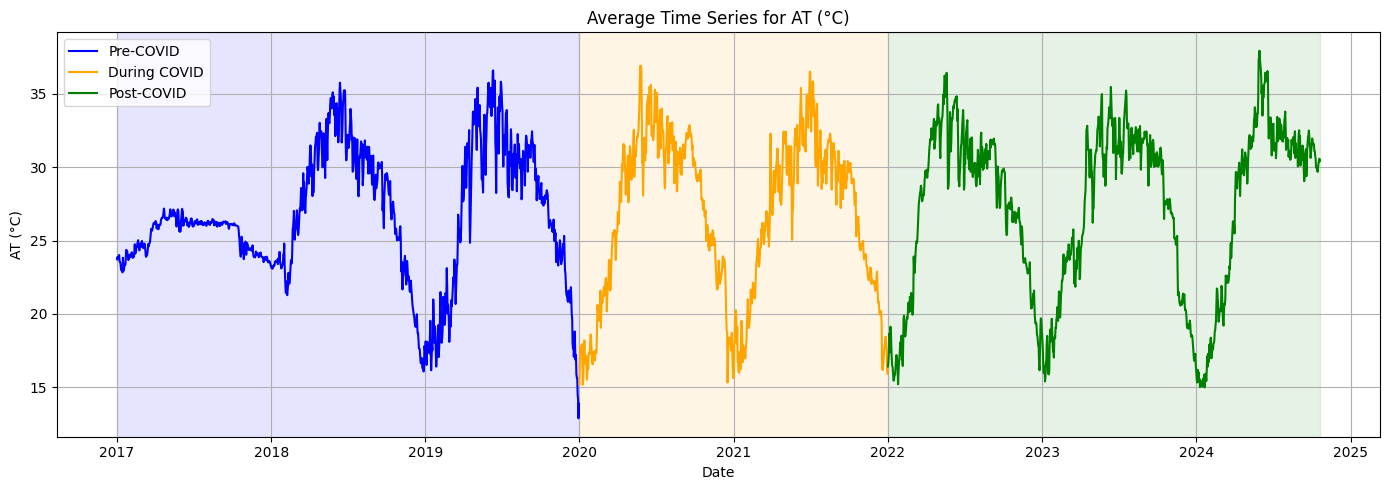

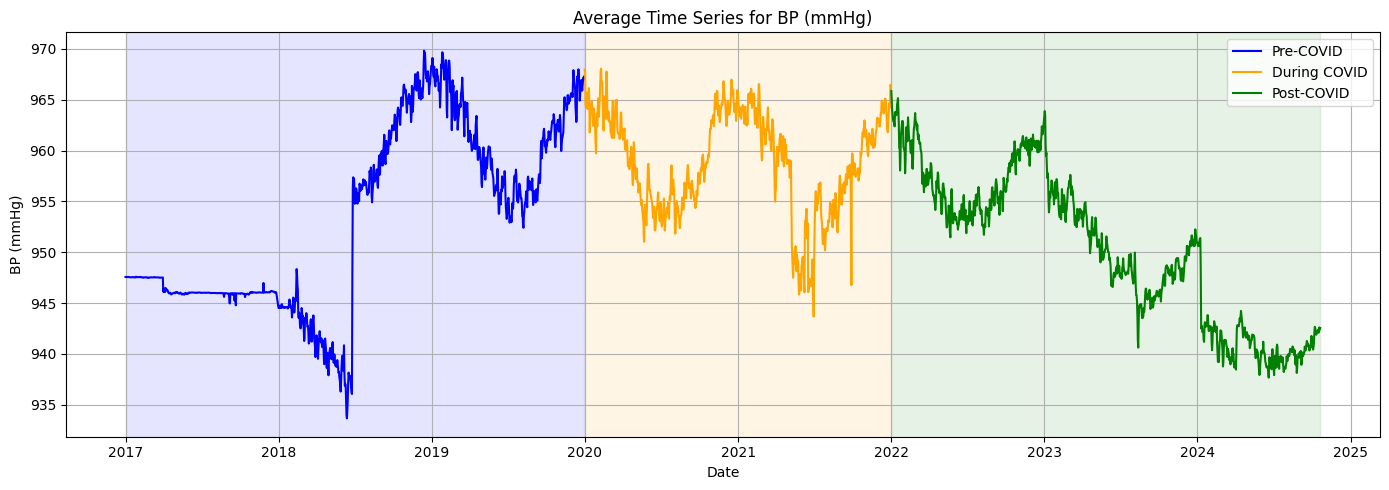

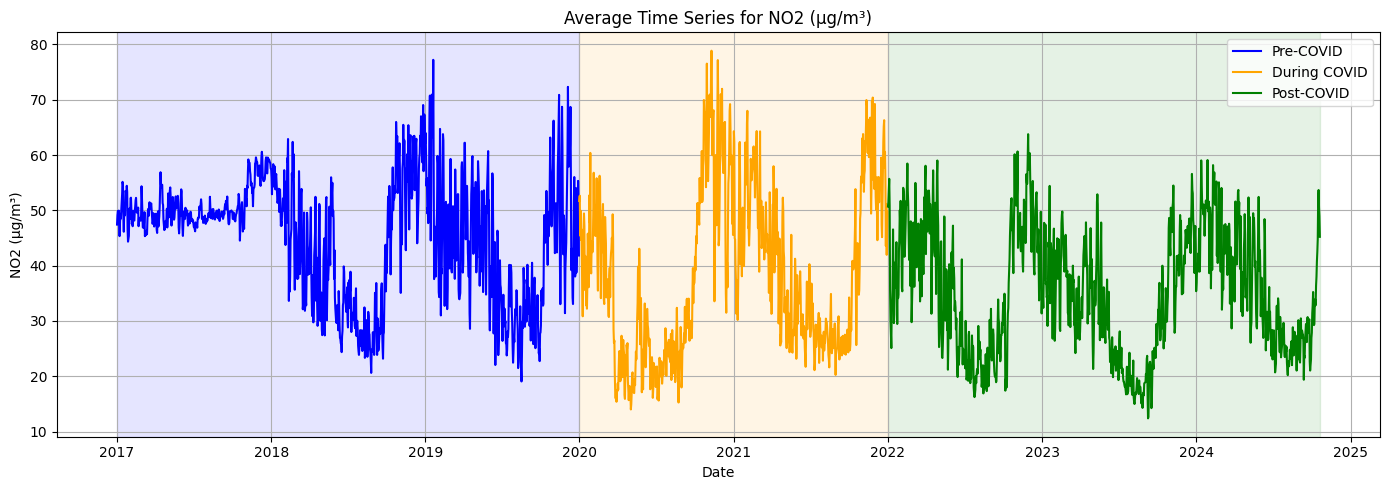

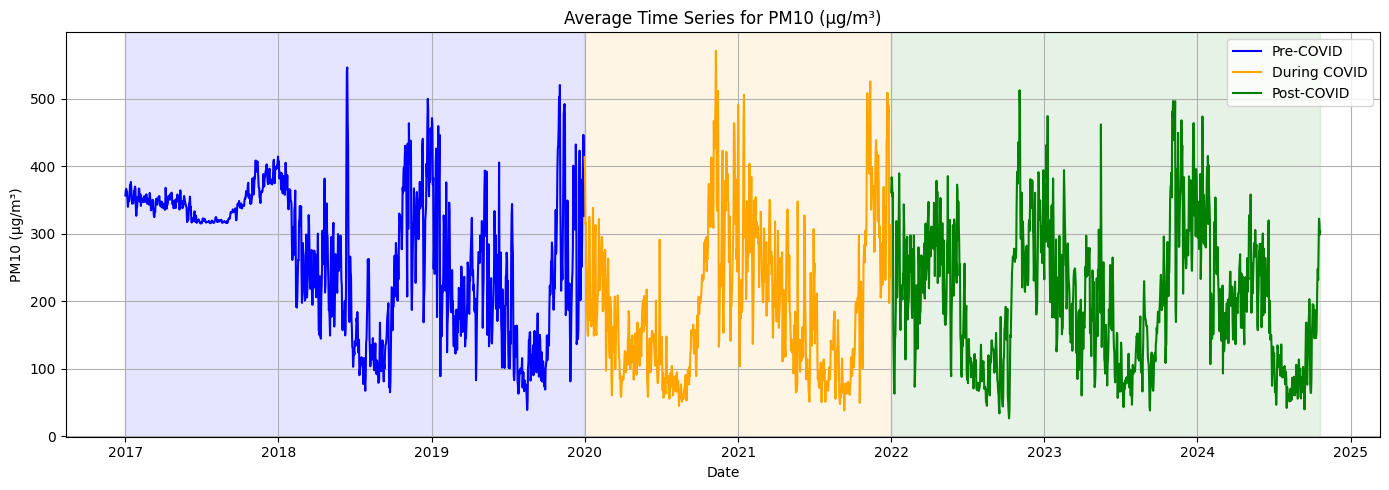

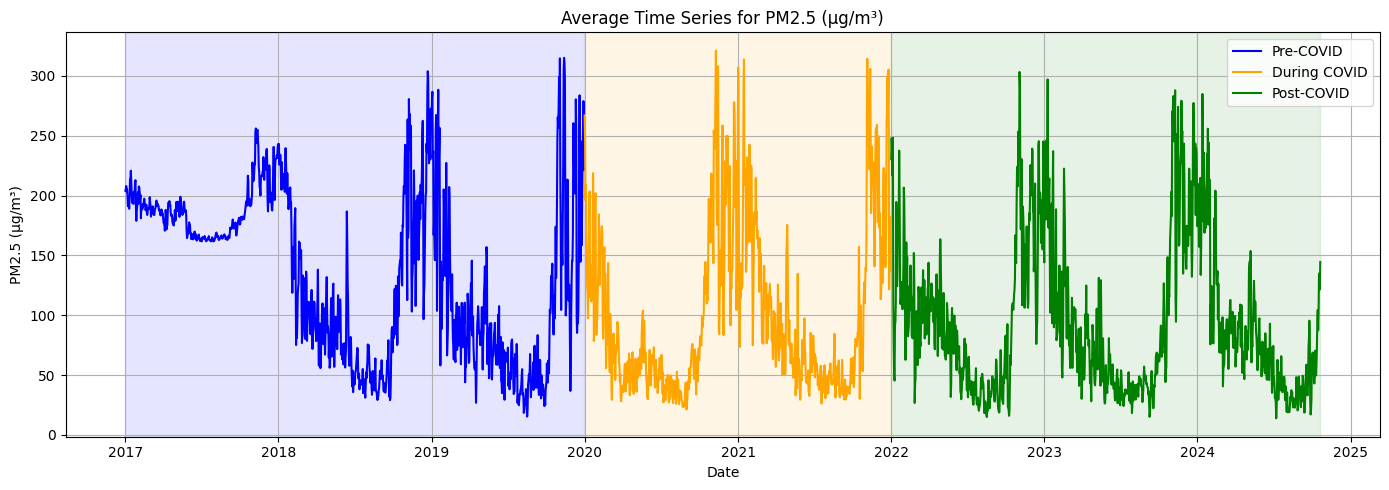

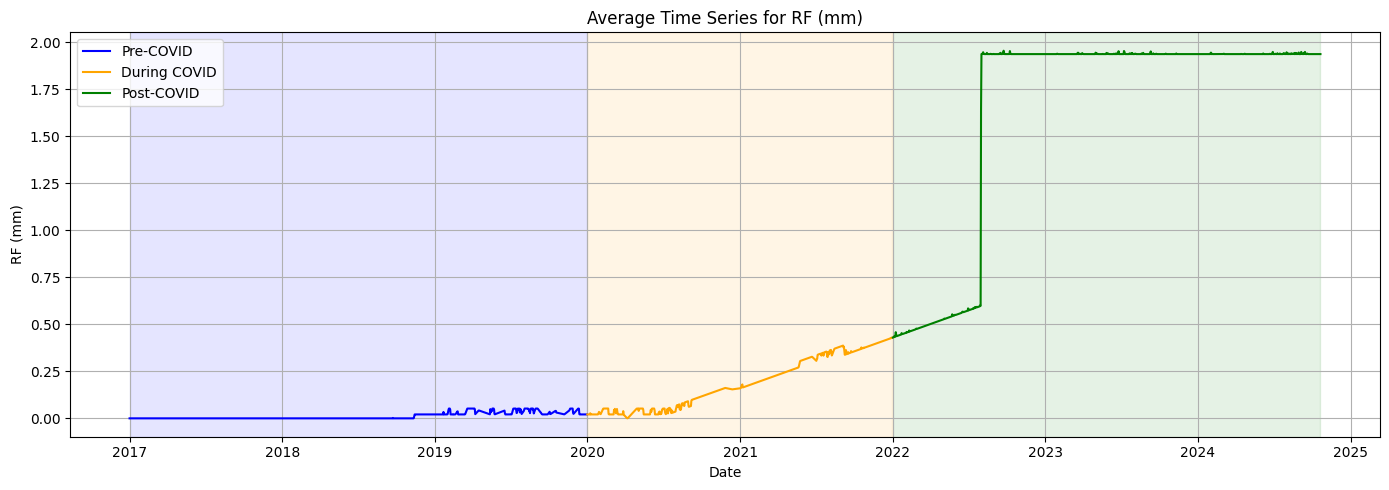

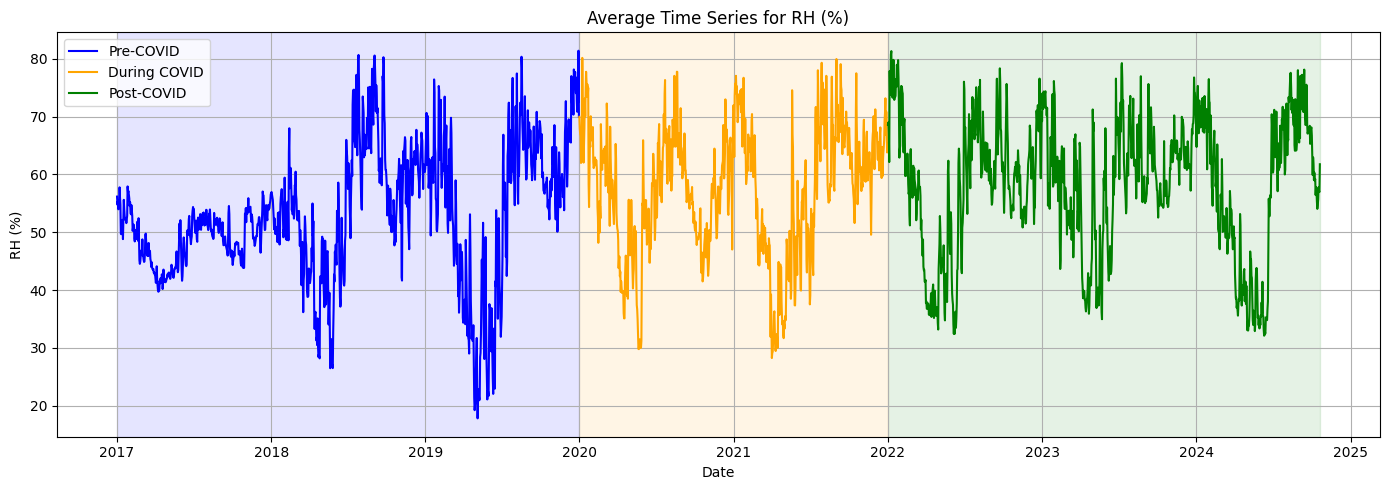

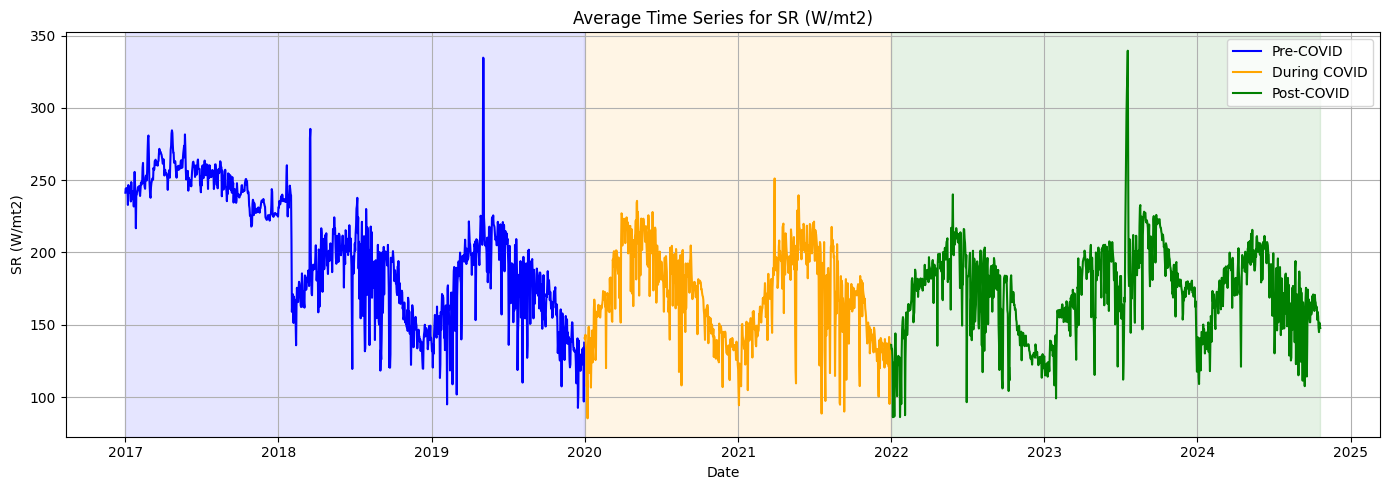

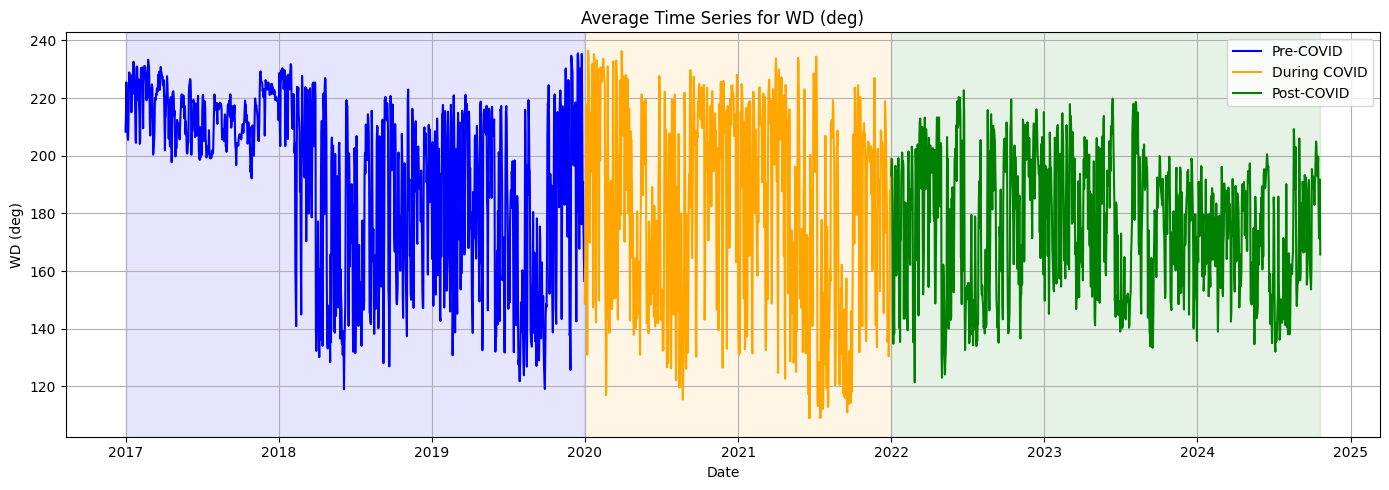

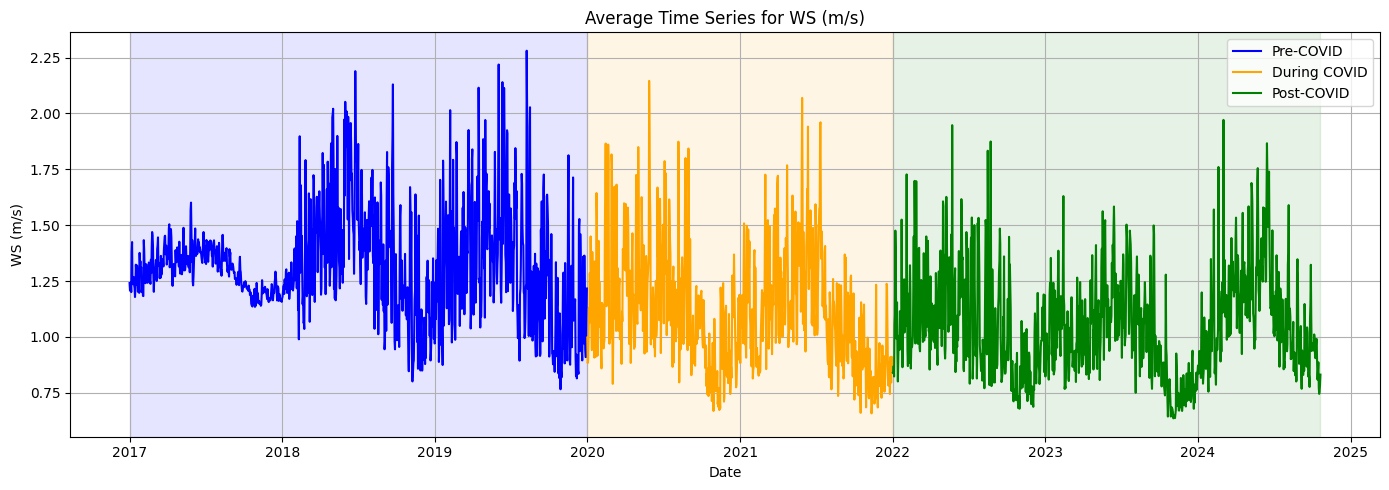

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Only convert and set Timestamp if it's still a column
if 'Timestamp' in preprocessed_df.columns:
    preprocessed_df['Timestamp'] = pd.to_datetime(preprocessed_df['Timestamp'])
    preprocessed_df.set_index('Timestamp', inplace=True)
else:
    preprocessed_df.index = pd.to_datetime(preprocessed_df.index)
# Step 2: Define columns to exclude
exclude_suffixes = ['.1', 'hour_weight', 'month_weight', 'of_week']

# Step 3: Extract unique, clean parameter names
parameter_set = set()
for col in preprocessed_df.columns:
    if '_' in col and not any(ex in col for ex in exclude_suffixes):
        _, param = col.split('_', 1)
        parameter_set.add(param.strip())

print("Filtered Unique Parameters:")
for param in sorted(parameter_set):
    print(param)

# Step 4: Resample for daily or monthly average
avg_type = 'D'  # 'M' for monthly
resampled_df = preprocessed_df.resample(avg_type).mean()

# Step 5: Plot each parameter
for param in sorted(parameter_set):
    matching_cols = [col for col in resampled_df.columns if col.endswith(param) and not any(ex in col for ex in exclude_suffixes)]
    if not matching_cols:
        continue

    param_avg = resampled_df[matching_cols].mean(axis=1)
    if param_avg.isna().all():
        continue

    # Split COVID timeline
    pre_covid = param_avg[param_avg.index < '2020-01-01']
    during_covid = param_avg[(param_avg.index >= '2020-01-01') & (param_avg.index < '2022-01-01')]
    post_covid = param_avg[param_avg.index >= '2022-01-01']

    # Plotting
    plt.figure(figsize=(14, 5))
    plt.plot(pre_covid.index, pre_covid, label='Pre-COVID', color='blue')
    plt.plot(during_covid.index, during_covid, label='During COVID', color='orange')
    plt.plot(post_covid.index, post_covid, label='Post-COVID', color='green')

    plt.axvspan(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-12-31'), alpha=0.1, color='blue')
    plt.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-12-31'), alpha=0.1, color='orange')
    plt.axvspan(pd.to_datetime('2022-01-01'), param_avg.index.max(), alpha=0.1, color='green')

    plt.title(f"Average Time Series for {param}")
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load weighted MI score data
mi_df = pd.read_csv('mi_calculation_based_on_distance.csv')

# Aggregate mean weighted MI score per Main_Station
station_scores = mi_df.groupby('Main_Station')['Weighted_MI_Score'].mean().reset_index()

# Scale the Weighted_MI_Score for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(station_scores[['Weighted_MI_Score']])

# Perform KMeans clustering into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
station_scores['Cluster'] = kmeans.fit_predict(X_scaled)

# Get cluster centers for info (scaled back to original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

print("Cluster centers (Weighted MI Score):", centers.flatten())

# Select best station (highest weighted MI score) in each cluster
best_stations = station_scores.loc[station_scores.groupby('Cluster')['Weighted_MI_Score'].idxmax()].reset_index(drop=True)

print("Best stations from each cluster:")
print(best_stations[['Main_Station', 'Cluster', 'Weighted_MI_Score']])


Cluster centers (Weighted MI Score): [0.05219572 0.02742407 0.08566107]
Best stations from each cluster:
        Main_Station  Cluster  Weighted_MI_Score
0         Patparganj        0           0.066066
1  CRRI Mathura Road        1           0.037526
2               Pusa        2           0.101098


In [ ]:
print(station_scores)

                      main_station  weighted_mi_score  cluster
0                           Alipur           0.037210        1
1                      Anand Vihar           0.032991        1
2                      Ashok Vihar           0.088132        2
3                        Aya Nagar           0.013799        1
4                           Bawana           0.036307        1
5                  Burari Crossing           0.036221        1
6                CRRI Mathura Road           0.037526        1
7                    Chandni Chowk           0.047224        0
8                              DTU           0.021248        1
9   Dr. Karni Singh Shooting Range           0.045814        0
10                 Dwarka-Sector 8           0.027900        1
11                    Jahangirpuri           0.052667        0
12        Jawaharlal Nehru Stadium           0.074090        2
13                     Mandir Marg           0.022970        1
14                     NSIT Dwarka           0.016636  

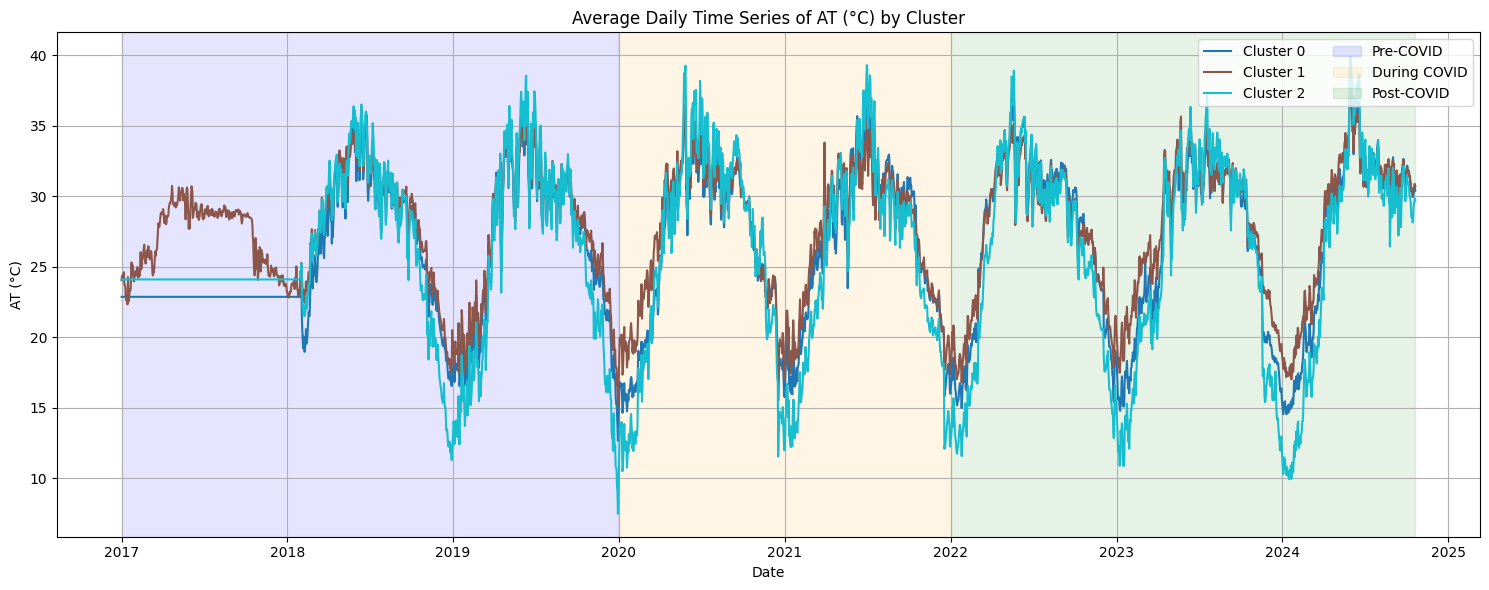

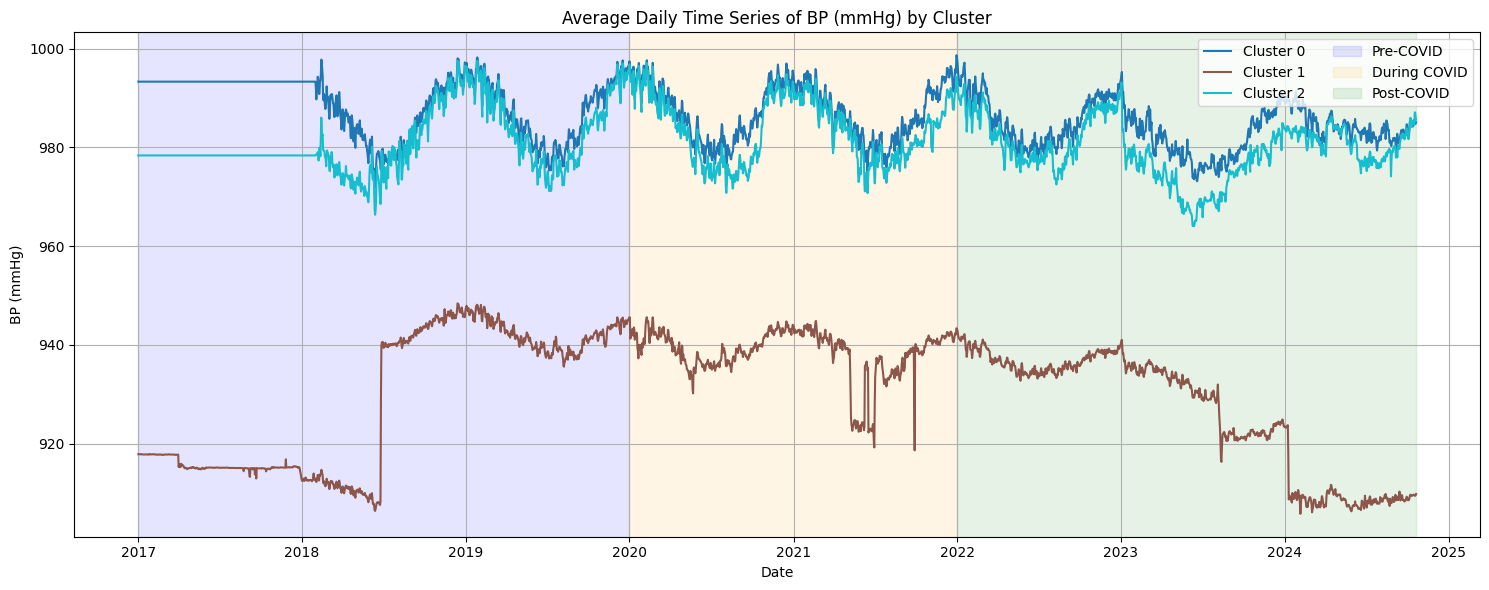

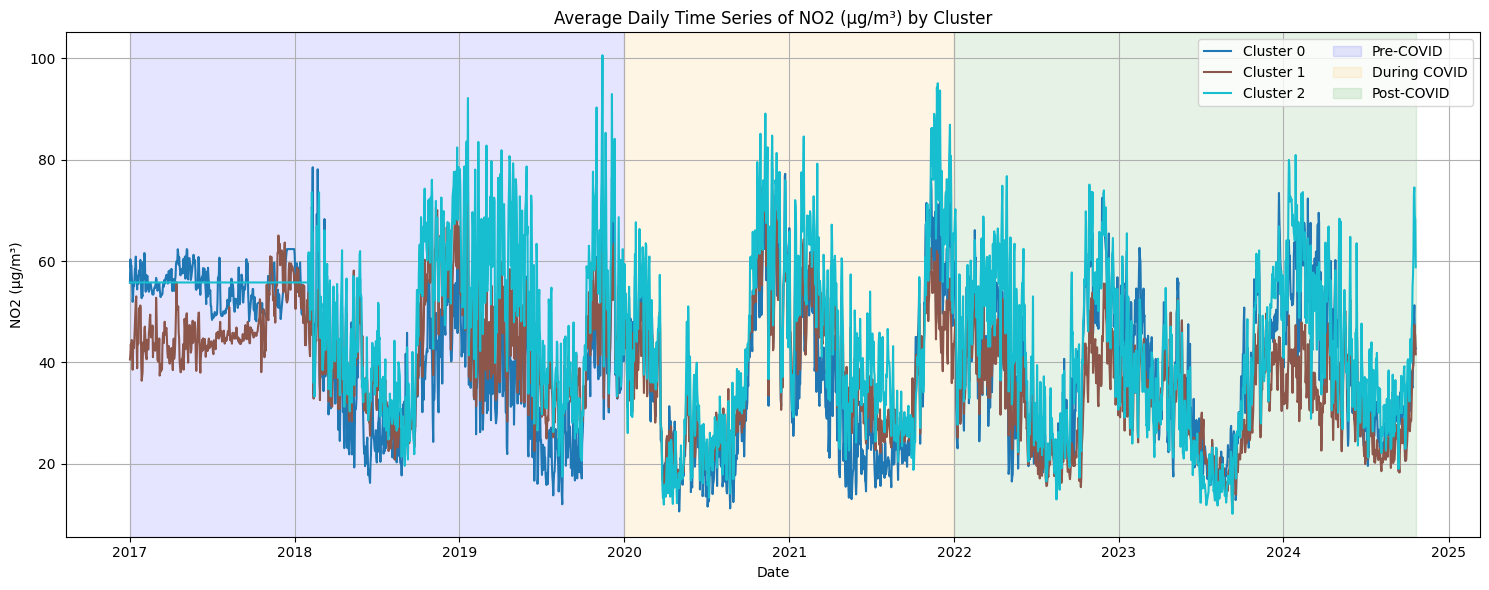

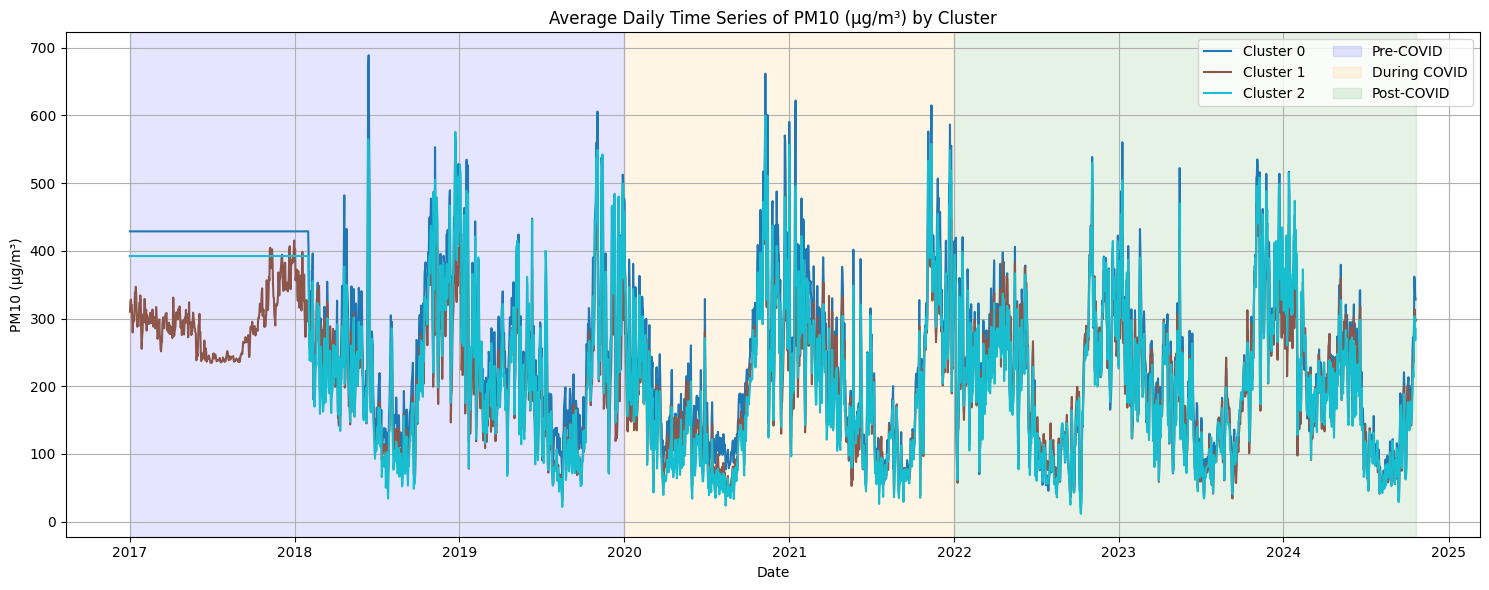

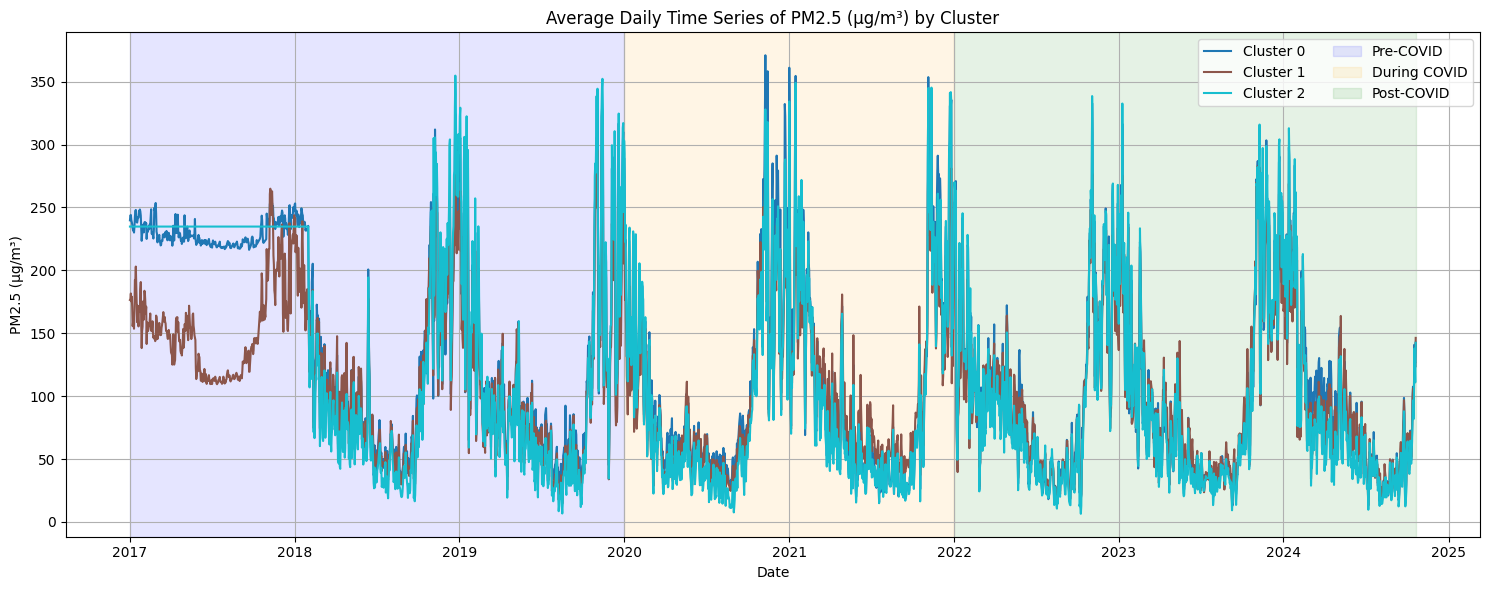

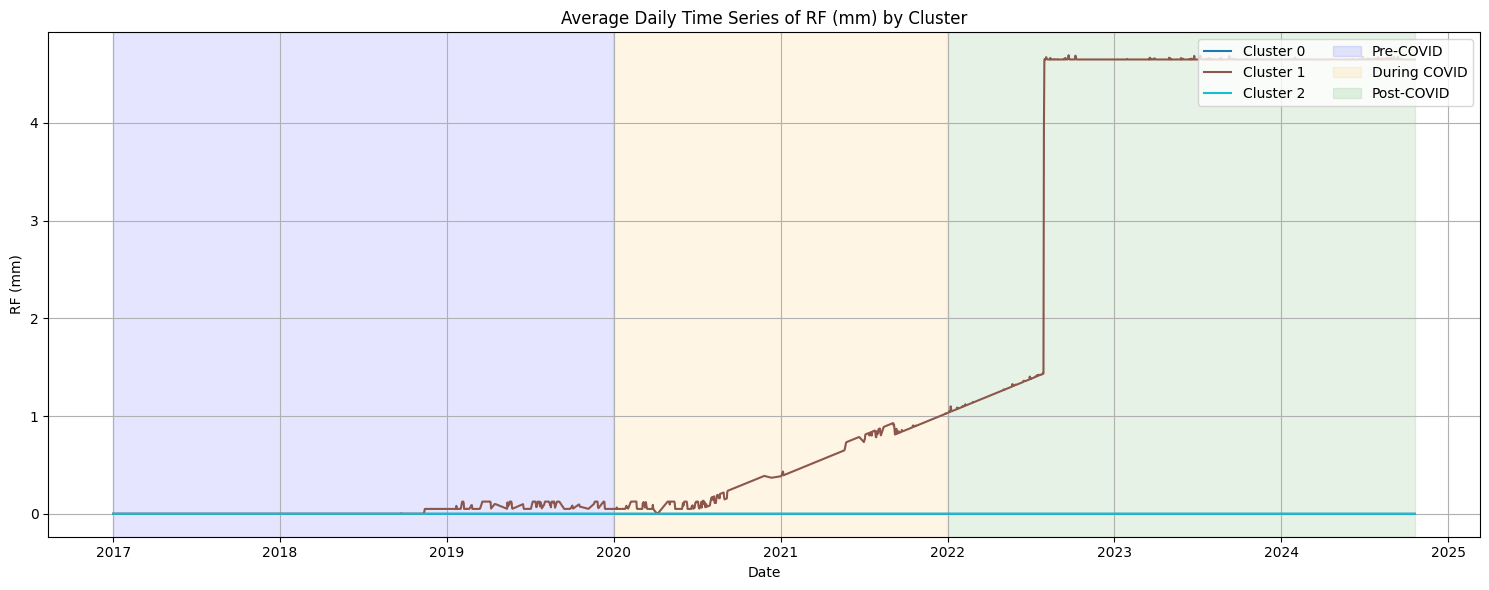

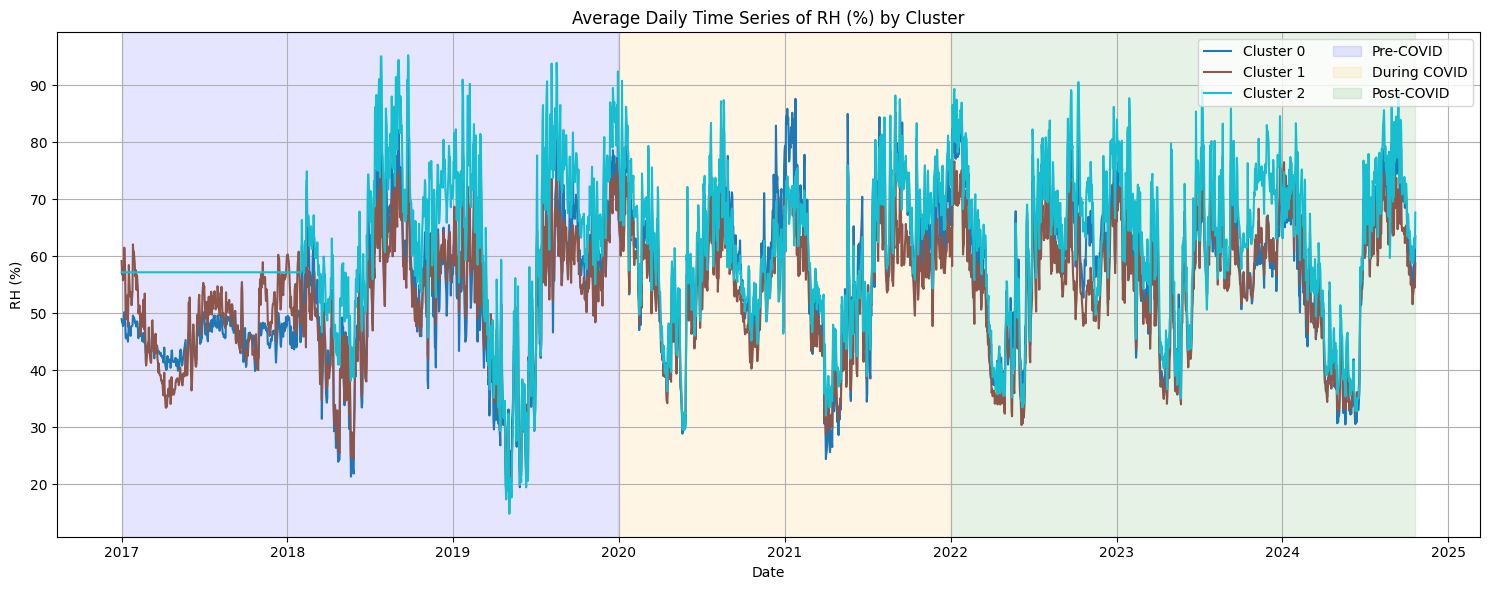

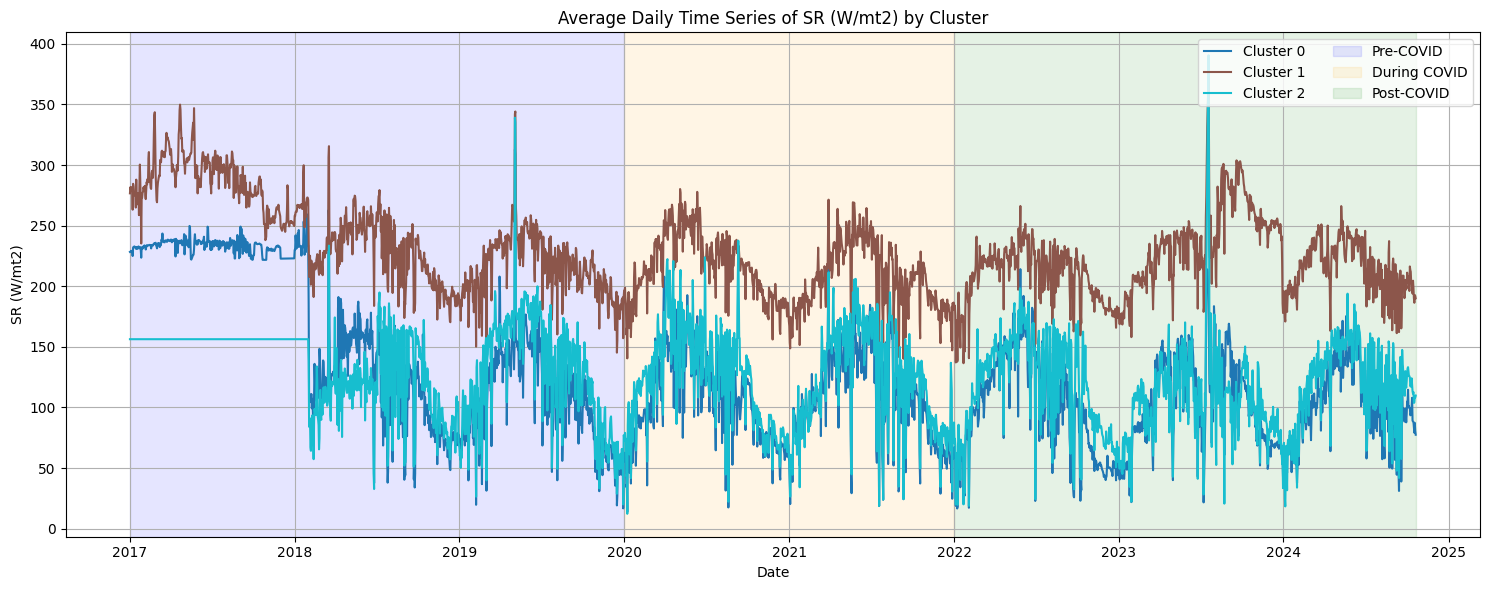

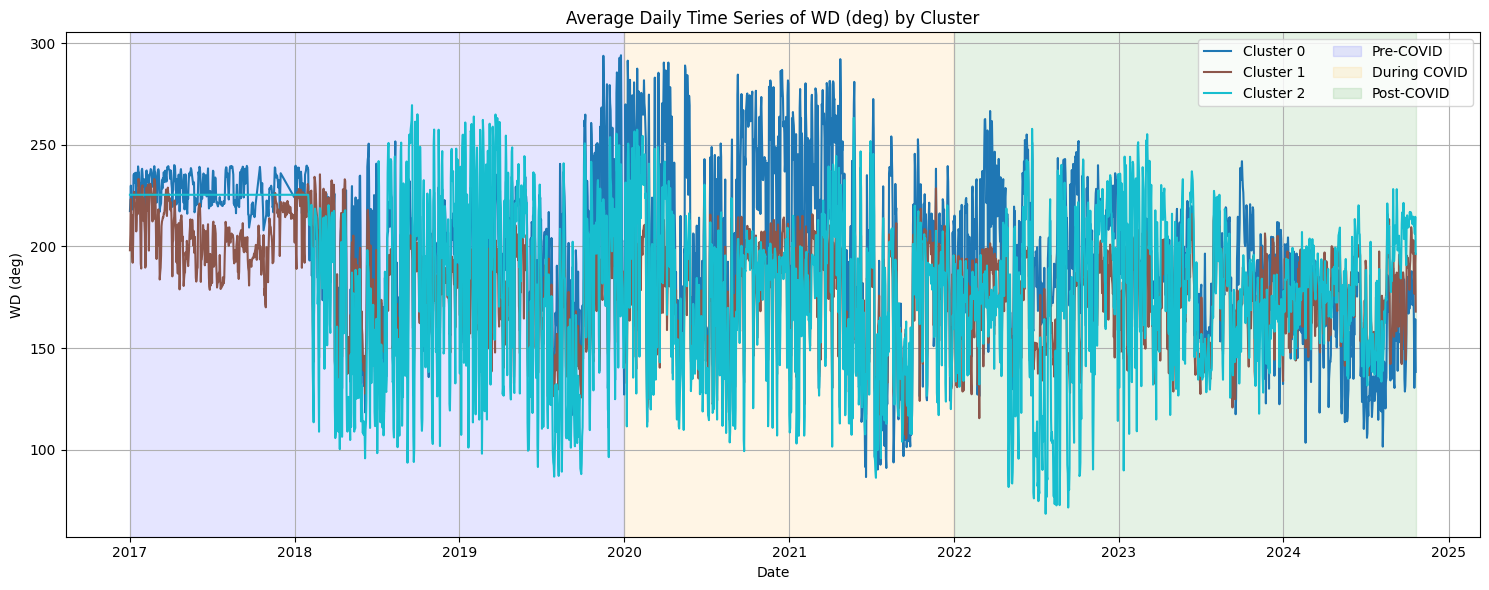

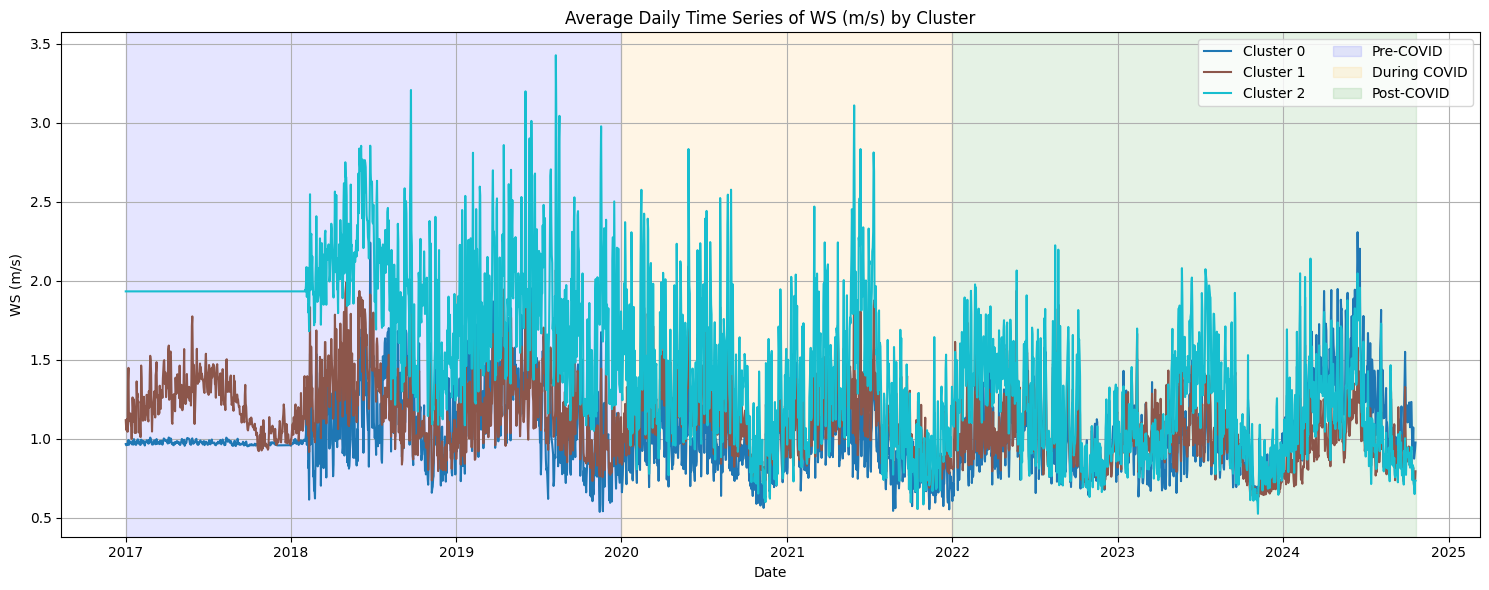

In [ ]:
#cluster wise parameter analysis
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import defaultdict

# Step 1: Ensure datetime index
preprocessed_df.index = pd.to_datetime(preprocessed_df.index)

# Step 2: Clean and map station to cluster
station_scores.columns = station_scores.columns.str.strip().str.lower()
station_cluster_map = dict(zip(station_scores['main_station'], station_scores['cluster']))

# Step 3: Reverse mapping of clusters to station names
cluster_to_stations = defaultdict(list)
for station, cluster in station_cluster_map.items():
    cluster_to_stations[cluster].append(station)

# Step 4: Extract all unique parameters (ignoring .1 and weights)
valid_columns = [col for col in preprocessed_df.columns if '_' in col and not col.endswith(('.1', 'hour_weight', 'month_weight', 'of_week'))]
unique_params = sorted(set(col.split('_', 1)[1] for col in valid_columns))

# Step 5: Daily average
daily_df = preprocessed_df.resample('D').mean()

# Step 6: Colors for clusters
num_clusters = len(cluster_to_stations)
colors = cm.tab10(np.linspace(0, 1, num_clusters))

# Step 7: Iterate through each unique parameter
for param in unique_params:
    plt.figure(figsize=(15, 6))

    found = False  # flag to avoid plotting empty plots

    # Plot each cluster
    for i, (cluster, stations) in enumerate(sorted(cluster_to_stations.items())):
        # Get columns for this parameter and cluster stations
        matching_cols = [f"{station}_{param}" for station in stations if f"{station}_{param}" in daily_df.columns]
        if not matching_cols:
            continue

        # Average the parameter across stations in this cluster
        cluster_avg = daily_df[matching_cols].mean(axis=1)
        if cluster_avg.dropna().empty:
            continue

        found = True
        plt.plot(cluster_avg.index, cluster_avg, label=f"Cluster {cluster}", color=colors[i])

    if not found:
        plt.close()
        continue

    # Add COVID period shading
    plt.axvspan(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-12-31'), alpha=0.1, color='blue', label='Pre-COVID')
    plt.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-12-31'), alpha=0.1, color='orange', label='During COVID')
    plt.axvspan(pd.to_datetime('2022-01-01'), cluster_avg.index.max(), alpha=0.1, color='green', label='Post-COVID')

    # Labels and legend
    plt.title(f"Average Daily Time Series of {param} by Cluster")
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.grid(True)
    plt.legend(loc='upper right', ncol=2)
    plt.tight_layout()
    plt.show()


In [ ]:
#cluster plot in browser
#some format error
import pandas as pd
import plotly.express as px
import nbformat

# Load location data
location_df = pd.read_csv(r'C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\location.csv')
location_df.columns = location_df.columns.str.strip().str.lower()

# Load and clean station_scores (already clustered)
station_scores.columns = station_scores.columns.str.strip().str.lower()

# Merge with location data
merged_df = pd.merge(
    station_scores,
    location_df,
    how='left',
    left_on='main_station',
    right_on='location'
)

# Drop rows with missing coordinates
merged_df = merged_df.dropna(subset=['latitudes', 'longitudes'])

# Plot using Plotly Mapbox
fig = px.scatter_mapbox(
    merged_df,
    lat="latitudes",
    lon="longitudes",
    color="cluster",
    text="main_station",
    zoom=10,
    height=800,
    width=900,
    mapbox_style="open-street-map",
    color_continuous_scale=px.colors.qualitative.Set1
)

# Add station names as hover text
fig.update_traces(marker=dict(size=12), hovertemplate='<b>%{text}</b><br>Cluster: %{marker.color}')

# Final layout settings
fig.update_layout(
    title="Delhi AQI Stations Clustered by Weighted MI Score",
    title_x=0.5,
    margin=dict(l=10, r=10, t=40, b=10)
)

fig.show()

C:\Users\jains\AppData\Local\Temp\ipykernel_13008\194197617.py:25: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [ ]:
DATA_FILE = "preprocessed_data.csv"
MI_FILE = "mi_calculation_based_on_distance.csv"

In [ ]:
MI_THRESHOLD = 0.005

In [ ]:
# Load core datasets
df = pd.read_csv(DATA_FILE)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

mi_df = pd.read_csv(MI_FILE)
# cluster_df = pd.read_csv(STATION_CLUSTER_FILE)

# Model dictionary
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}


In [ ]:
all_results = []
all_feature_importance = []

for cluster_id in sorted(station_scores['cluster'].unique()):
    stations_in_cluster = station_scores[station_scores['cluster'] == cluster_id]['main_station'].tolist()
    print(f"\n--- Cluster {cluster_id}: {len(stations_in_cluster)} stations ---")

    for station in stations_in_cluster:
        target_col = f"{station}_PM2.5 (µg/m³)"
        if target_col not in df.columns:
            print(f"Skipping {station} - target not found.")
            continue

        df_station = df[['Timestamp', target_col, 'month', 'day_of_week', 'hour',
                         'PM2.5_month_weight', 'PM2.5_hour_weight']].copy()

        # Add features from MI-selected stations
        mi_subset = mi_df[(mi_df['Main_Station'] == station) & (mi_df['MI_Score'] >= MI_THRESHOLD)]
        for _, mi_row in mi_subset.iterrows():
            src_col = f"{mi_row['Source_Station']}_{mi_row['Parameter']}"
            if src_col in df.columns:
                df_station[src_col] = df[src_col]

        # Add main station's own meteorological features
        for col in df.columns:
            if col.startswith(f"{station}_") and col != target_col and "PM10" not in col:
                df_station[col] = df[col]

        df_station = df_station.dropna().sort_values('Timestamp')
        X = df_station.drop(columns=['Timestamp', target_col])
        y = df_station[target_col]

        train_mask = df_station['Timestamp'] < '2024-01-01'
        test_mask = df_station['Timestamp'] >= '2024-01-01'

        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)

            all_results.append({
                'Cluster': cluster_id,
                'Station': station,
                'Model': name,
                'Test_R2': r2_score(y_test, y_pred_test)
            })

            if hasattr(model, 'feature_importances_'):
                all_feature_importance.append(pd.DataFrame({
                    'Cluster': cluster_id,
                    'Station': station,
                    'Model': name,
                    'Feature': X.columns,
                    'Importance': model.feature_importances_
                }))



--- Cluster 0: 8 stations ---

--- Cluster 1: 17 stations ---

--- Cluster 2: 6 stations ---


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure cluster list is sorted
clusters = sorted(results_df['Cluster'].unique())

# Create subplots for each cluster
fig, axes = plt.subplots(nrows=len(clusters), ncols=1, figsize=(14, 5 * len(clusters)))

# If only one cluster, make sure axes is iterable
if len(clusters) == 1:
    axes = [axes]

for i, cluster_id in enumerate(clusters):
    cluster_data = results_df[results_df['Cluster'] == cluster_id]

    ax = axes[i]
    sns.barplot(data=cluster_data, x='Station', y='Test_R2', hue='Model', ax=ax)

    # Add value labels on top of bars
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):  # Avoid labeling NaNs
            ax.text(
                p.get_x() + p.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=9,
                color='black'
            )

    ax.set_title(f"Cluster {cluster_id} - R² Scores by Model")
    ax.set_xlabel("Station")
    ax.set_ylabel("Test R² Score")
    ax.tick_params(axis='x', rotation=90)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


: 

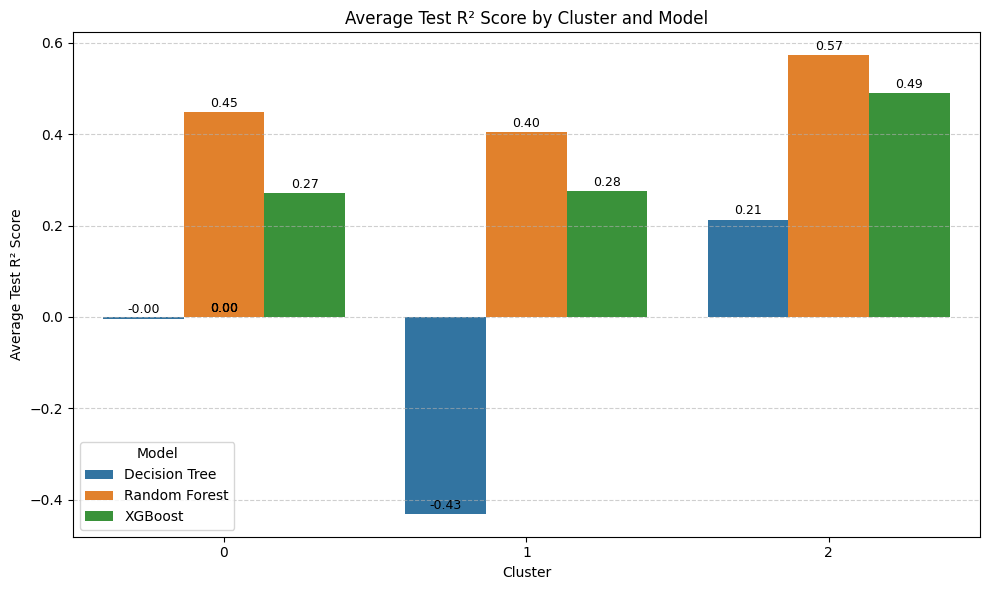

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by cluster and model to compute average Test R²
cluster_avg = results_df.groupby(['Cluster', 'Model'])['Test_R2'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_avg, x='Cluster', y='Test_R2', hue='Model')

# Add value labels
for p in plt.gca().patches:
    height = p.get_height()
    if not pd.isna(height):
        plt.gca().text(
            p.get_x() + p.get_width() / 2,
            height + 0.005,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )

plt.title("Average Test R² Score by Cluster and Model")
plt.xlabel("Cluster")
plt.ylabel("Average Test R² Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


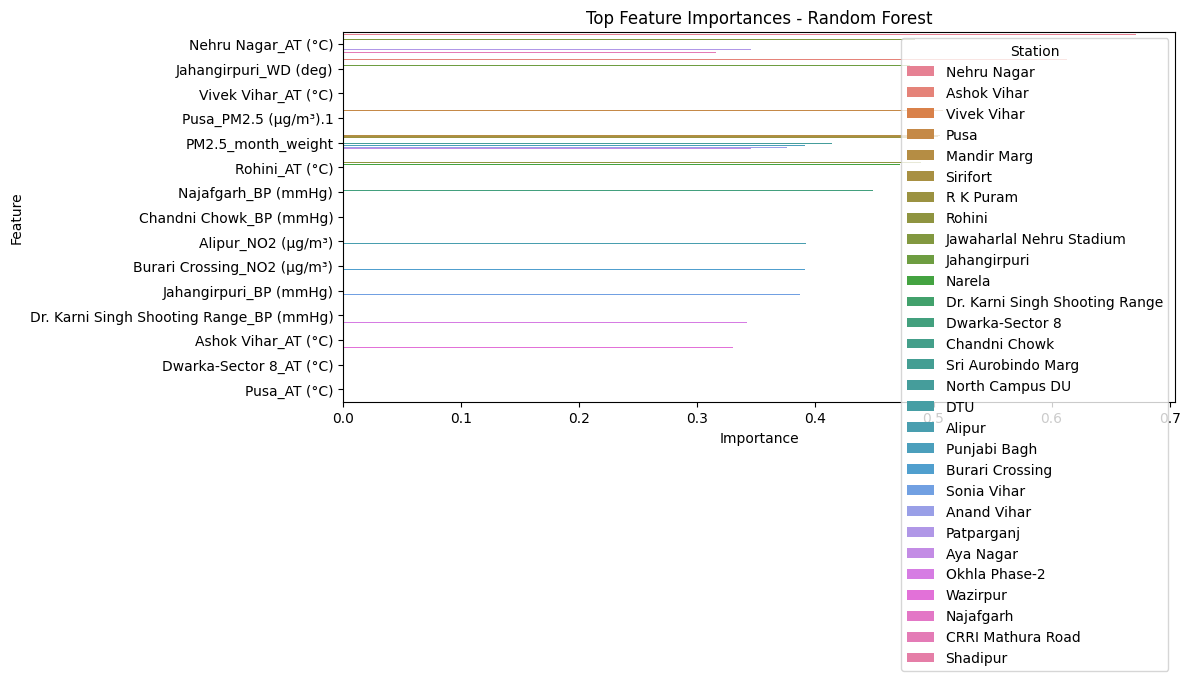

In [ ]:
fi_df = pd.concat(all_feature_importance, ignore_index=True)
top_rf = fi_df[fi_df['Model'] == 'Random Forest'].sort_values(by='Importance', ascending=False).head(30)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_rf, y='Feature', x='Importance', hue='Station')
plt.title("Top Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


In [ ]:
filtered_results = []

for cluster_id in sorted(station_scores['cluster'].unique()):
    stations = station_scores[station_scores['cluster'] == cluster_id]['main_station'].tolist()
    for station in stations:
        target_col = f"{station}_PM2.5 (µg/m³)"
        if target_col not in df.columns:
            continue

        rf_feats = fi_df[(fi_df['Station'] == station) & 
                         (fi_df['Model'] == 'Random Forest') & 
                         (fi_df['Importance'] > 0)]

        important_feats = rf_feats['Feature'].tolist()
        if not important_feats:
            continue

        df_station = df[['Timestamp', target_col] + important_feats].dropna().sort_values('Timestamp')
        X = df_station.drop(columns=['Timestamp', target_col])
        y = df_station[target_col]

        train_mask = df_station['Timestamp'] < '2024-01-01'
        test_mask = df_station['Timestamp'] >= '2024-01-01'

        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_pred_test = rf.predict(X_test)

        filtered_results.append({
            'Cluster': cluster_id,
            'Station': station,
            'Model': 'Random Forest (Filtered)',
            'Test_R2': r2_score(y_test, y_pred_test)
        })


In [ ]:
filtered_results_df = pd.DataFrame(filtered_results)

# Print results for each cluster
for cluster_id in sorted(filtered_results_df['Cluster'].unique()):
    cluster_data = filtered_results_df[filtered_results_df['Cluster'] == cluster_id]
    print(f"\n📊 Cluster {cluster_id} - Filtered Random Forest Performance")
    print("=" * 50)
    print(cluster_data[['Station', 'Test_R2']].to_string(index=False))



📊 Cluster 0 - Filtered Random Forest Performance
                       Station  Test_R2
                 Chandni Chowk 0.047496
Dr. Karni Singh Shooting Range 0.704676
                  Jahangirpuri 0.554140
                 Okhla Phase-2 0.666278
                    Patparganj 0.563899
                        Rohini 0.428055
                      Sirifort 0.216846
                   Vivek Vihar 0.429795

📊 Cluster 1 - Filtered Random Forest Performance
          Station   Test_R2
           Alipur  0.561478
      Anand Vihar  0.320299
        Aya Nagar -0.043062
           Bawana  0.596632
  Burari Crossing  0.054037
CRRI Mathura Road  0.351114
              DTU -0.045845
  Dwarka-Sector 8  0.561229
      Mandir Marg  0.578797
      NSIT Dwarka  0.225572
        Najafgarh  0.572705
           Narela  0.677124
  North Campus DU  0.373296
     Punjabi Bagh  0.688348
        R K Puram  0.665458
         Shadipur  0.456113
      Sonia Vihar  0.249030

📊 Cluster 2 - Filtered Random Fores

C:\Users\jains\AppData\Local\Temp\ipykernel_13008\1841354797.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




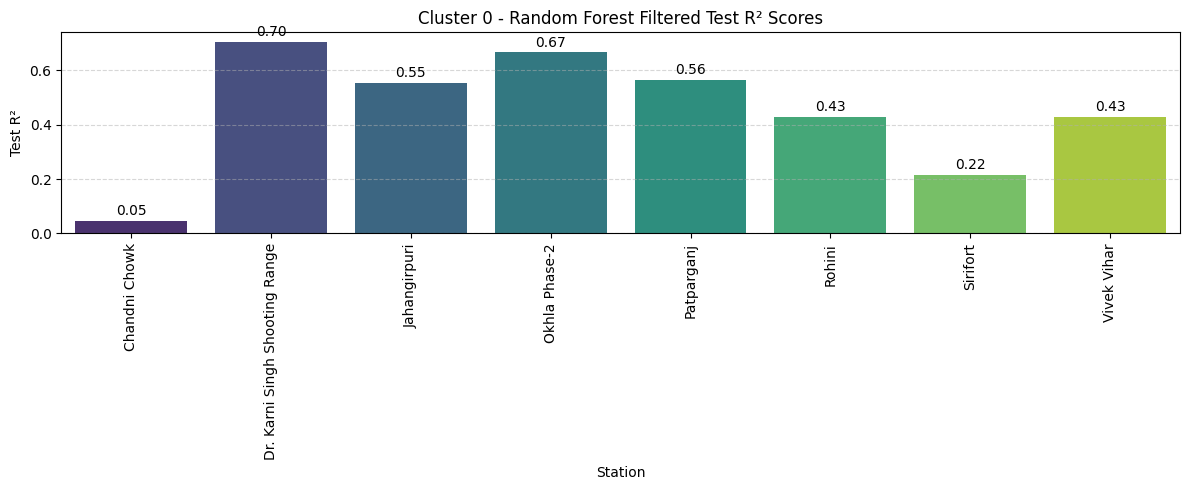

C:\Users\jains\AppData\Local\Temp\ipykernel_13008\1841354797.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




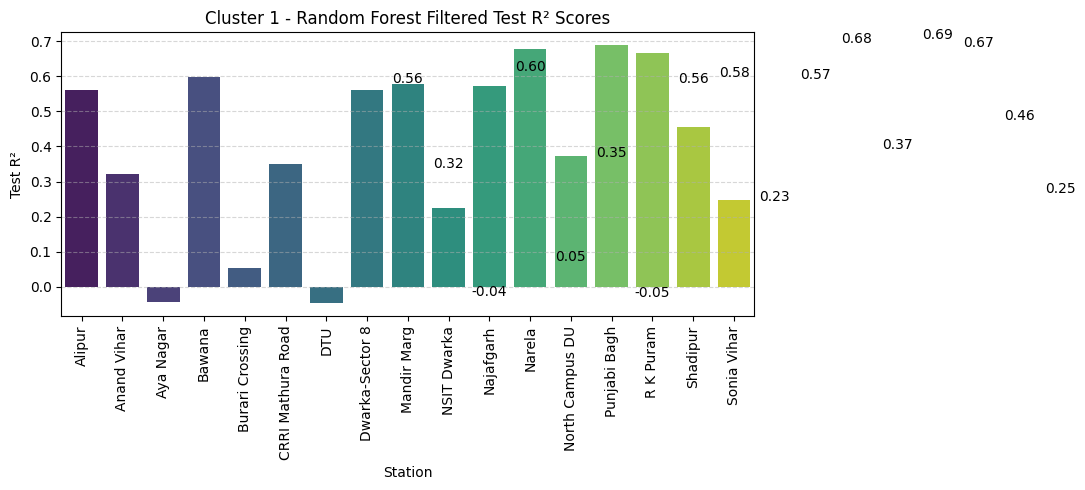

C:\Users\jains\AppData\Local\Temp\ipykernel_13008\1841354797.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\jains\AppData\Local\Temp\ipykernel_13008\1841354797.py:19: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



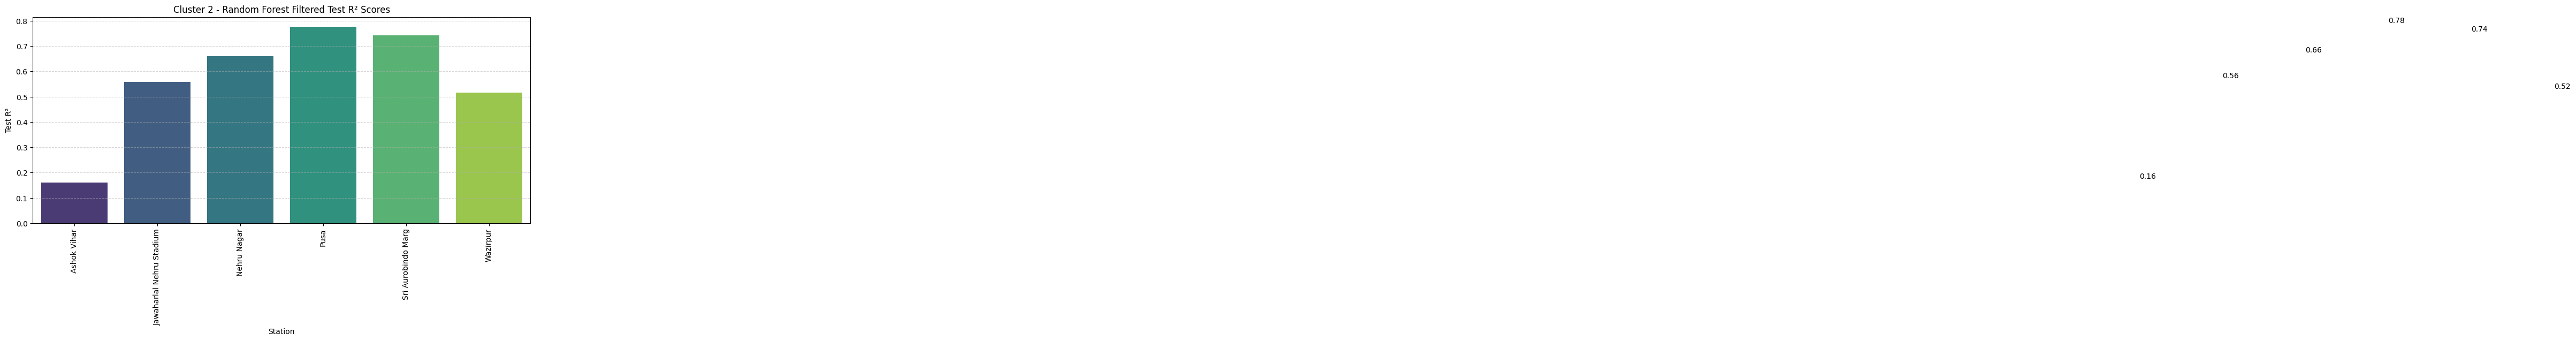

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for each cluster separately
for cluster_id in sorted(filtered_results_df['Cluster'].unique()):
    cluster_data = filtered_results_df[filtered_results_df['Cluster'] == cluster_id]

    plt.figure(figsize=(12, 5))
    sns.barplot(data=cluster_data, x='Station', y='Test_R2', palette='viridis')
    plt.title(f'Cluster {cluster_id} - Random Forest Filtered Test R² Scores')
    plt.xticks(rotation=90)
    
    # Add values on bars
    for index, row in cluster_data.iterrows():
        plt.text(index, row['Test_R2'] + 0.01, f"{row['Test_R2']:.2f}", ha='center', va='bottom')

    plt.ylabel("Test R²")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



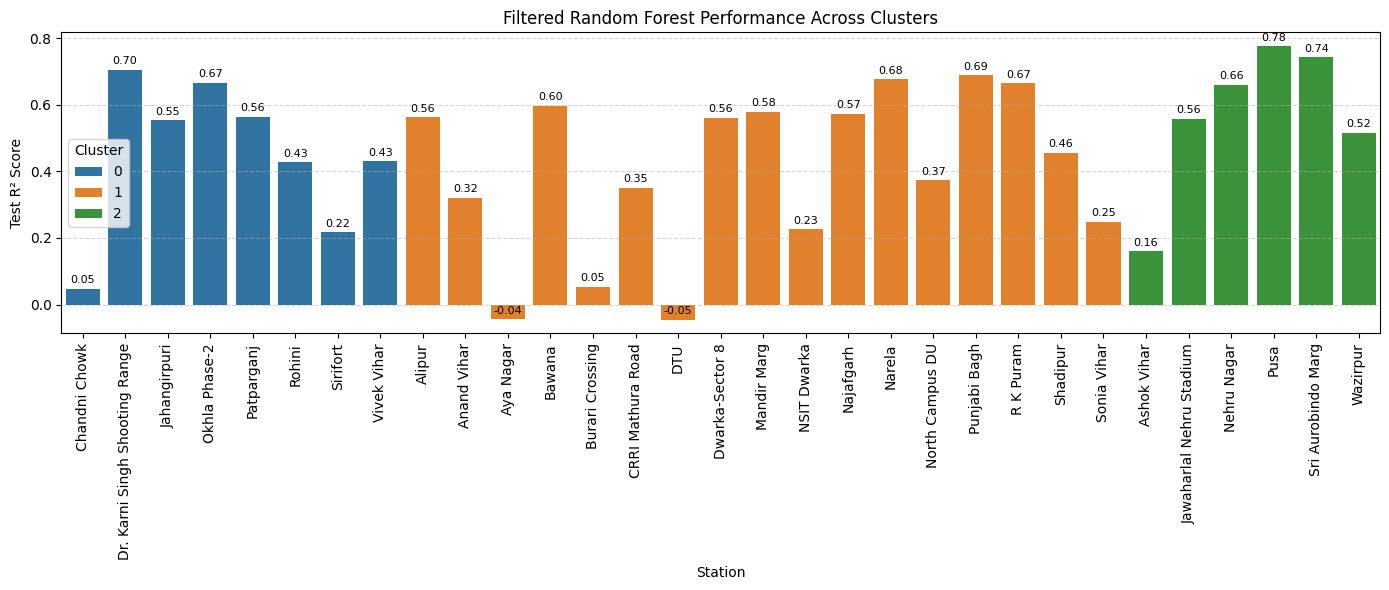

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(data=filtered_results_df, x='Station', y='Test_R2', hue='Cluster', palette='tab10')
plt.title("Filtered Random Forest Performance Across Clusters")
plt.xticks(rotation=90)

# Add value annotations
for index, row in filtered_results_df.iterrows():
    plt.text(index, row['Test_R2'] + 0.01, f"{row['Test_R2']:.2f}", ha='center', va='bottom', fontsize=8)

plt.ylabel("Test R² Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\jains\AppData\Local\Temp\ipykernel_13008\2960620489.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\jains\AppData\Local\Temp\ipykernel_13008\2960620489.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\jains\AppData\Local\Temp\ipykernel_13008\2960620489.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\jains\AppData\Local\Temp\ipykernel_13008\2960620489.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sam

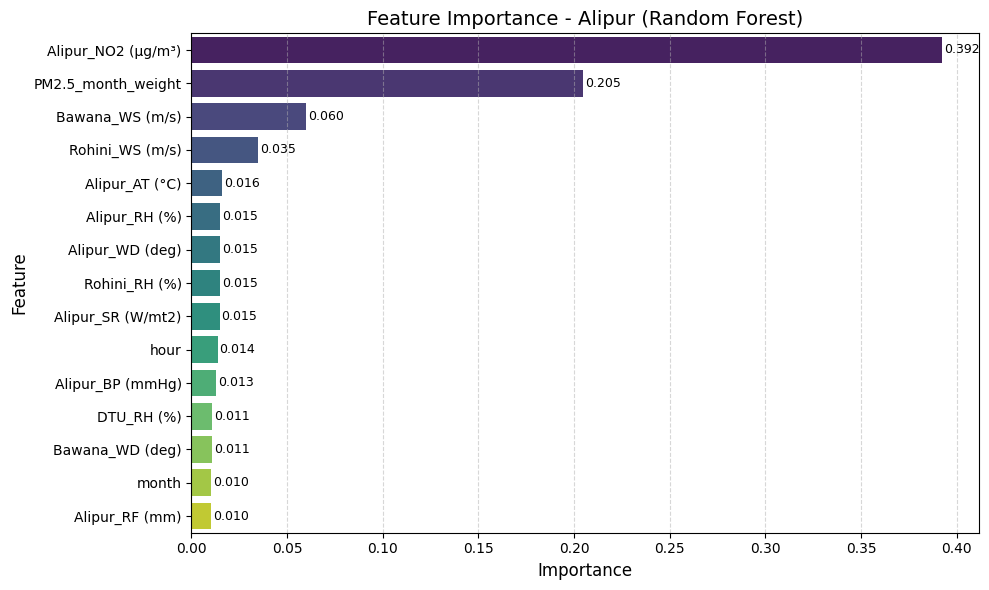

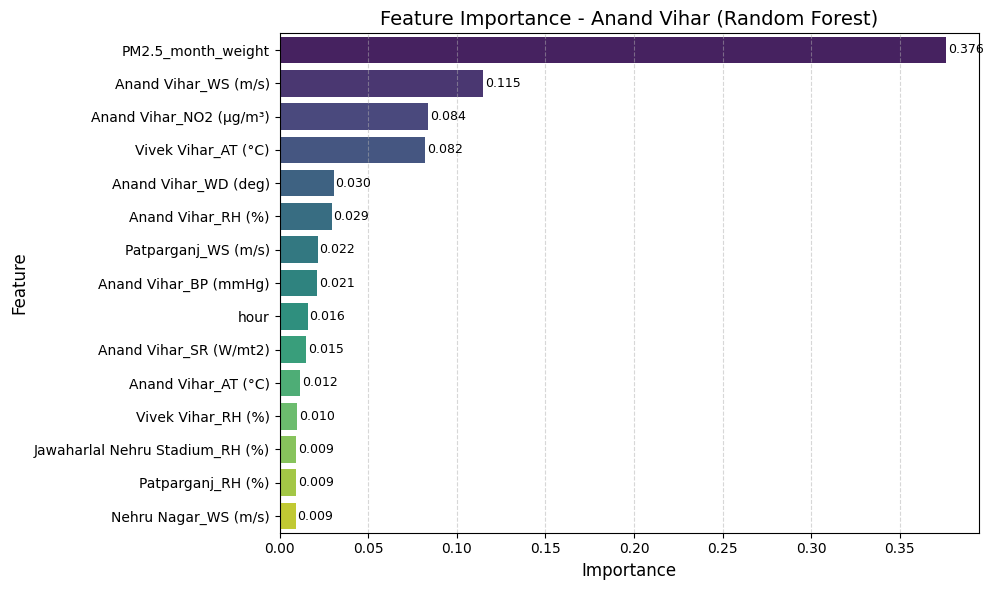

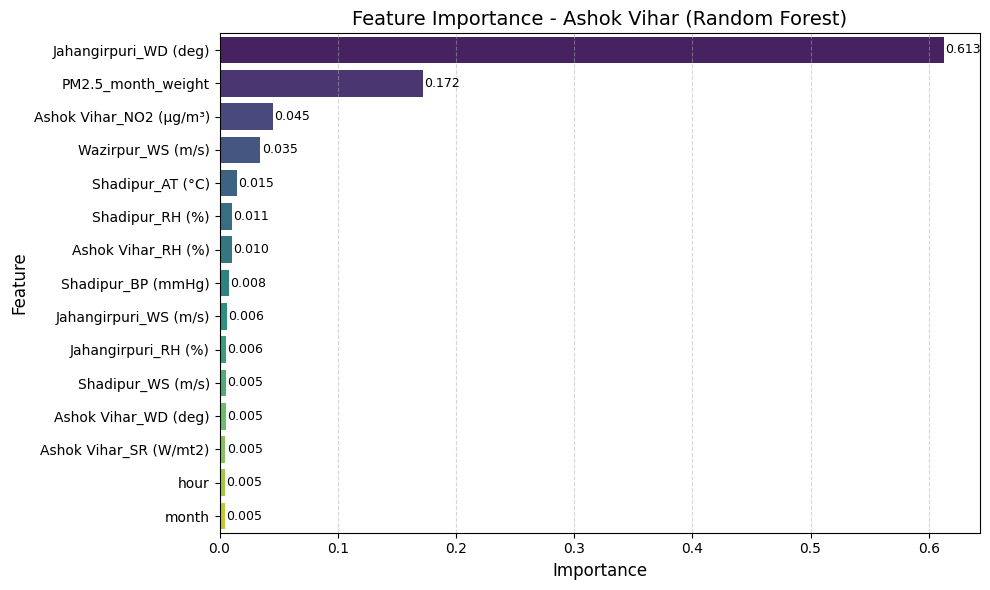

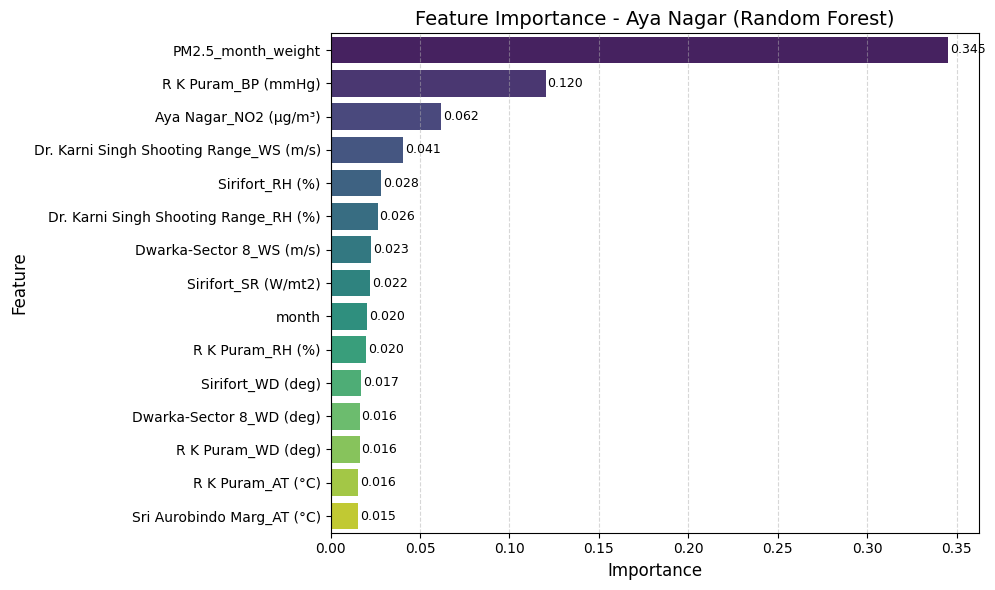

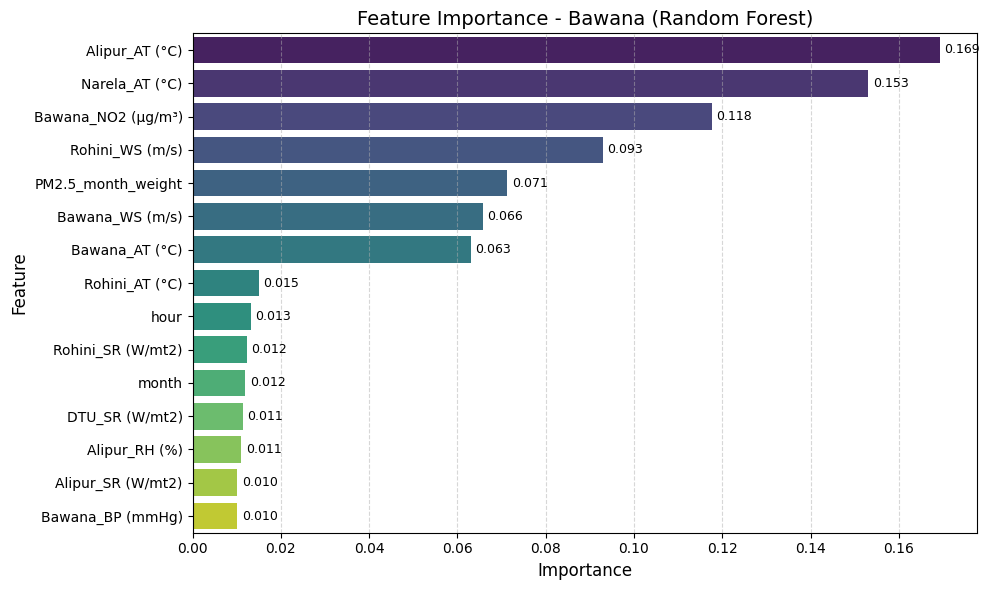

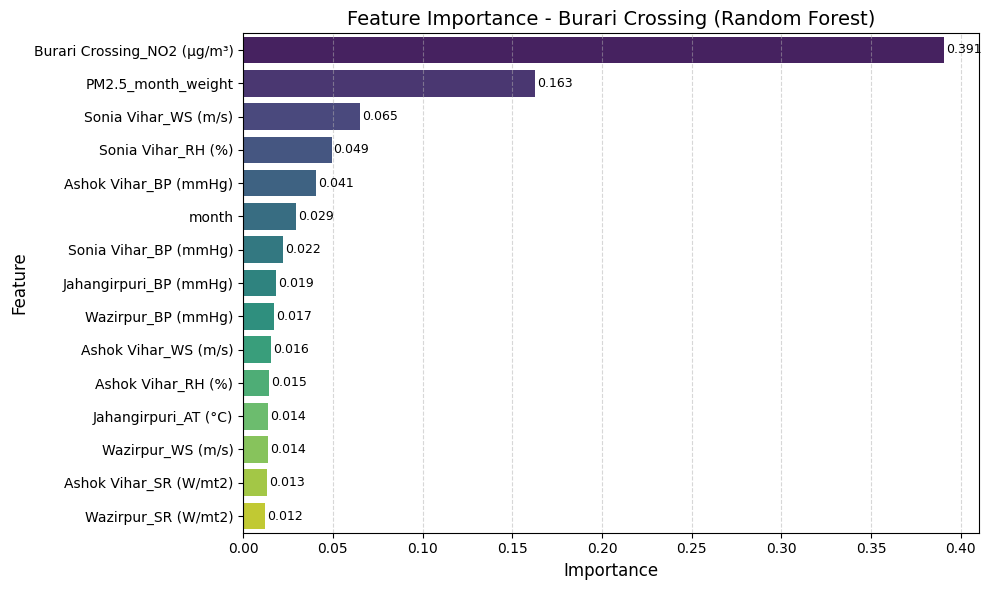

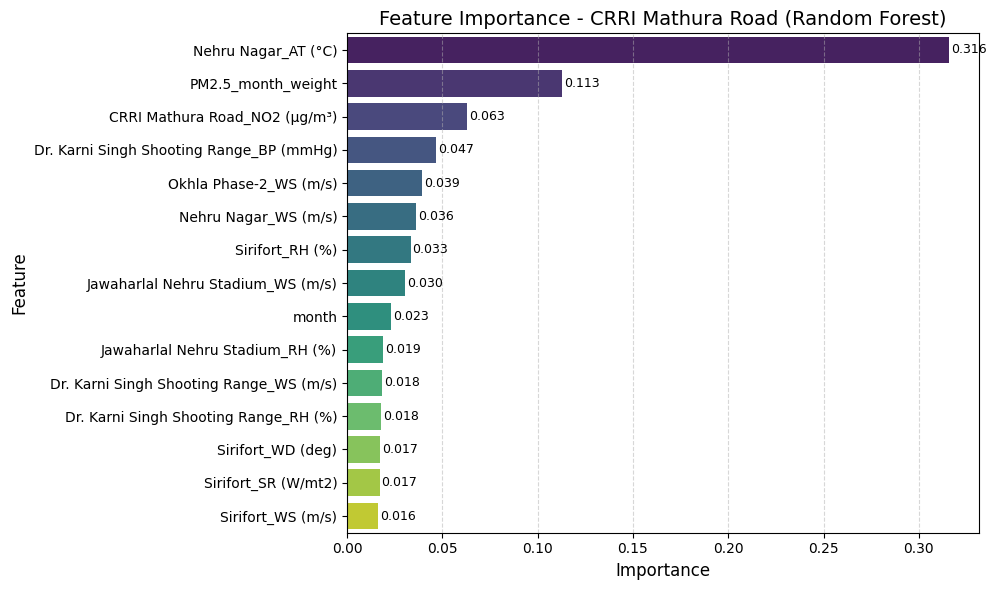

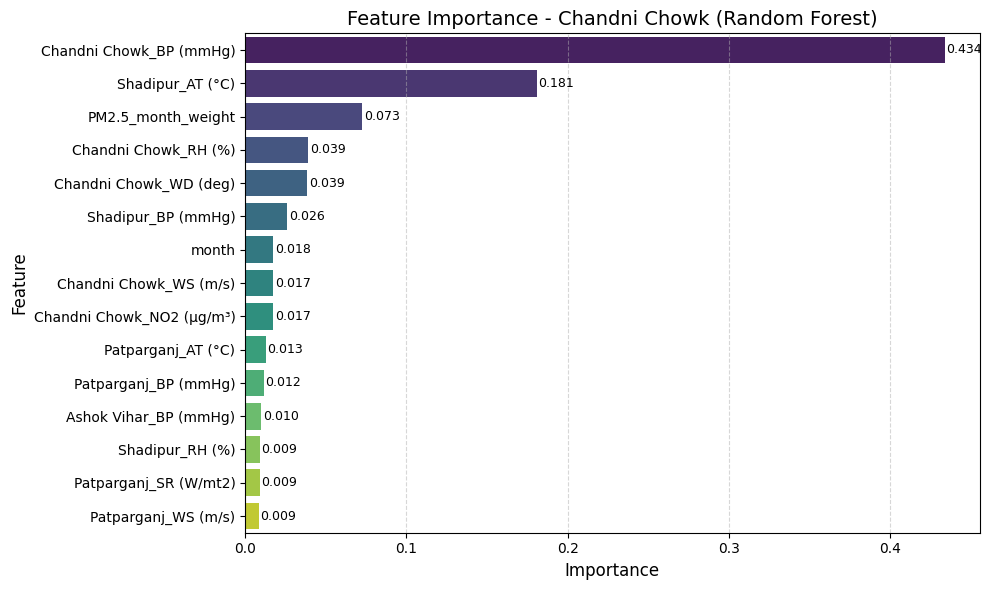

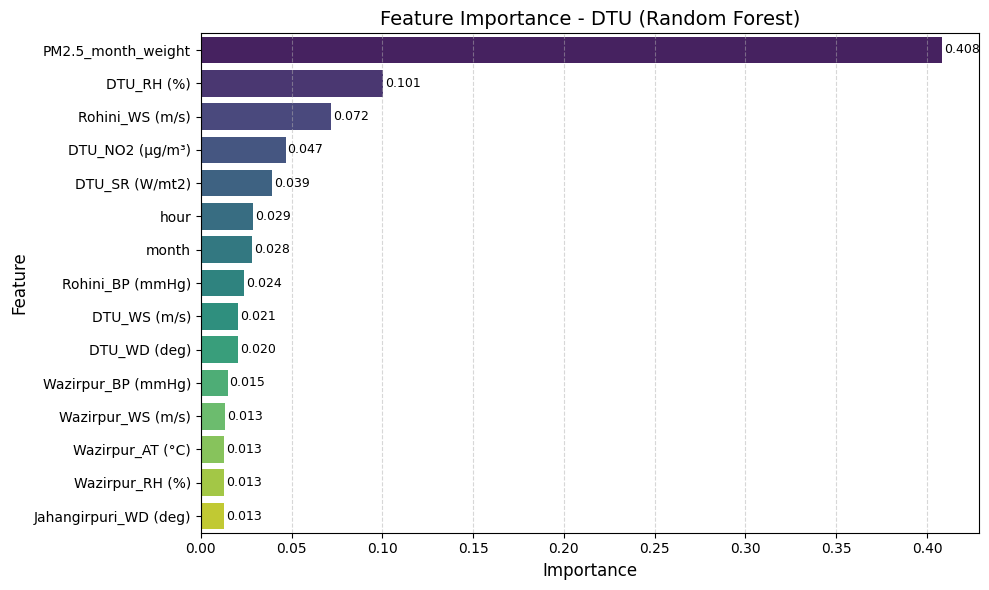

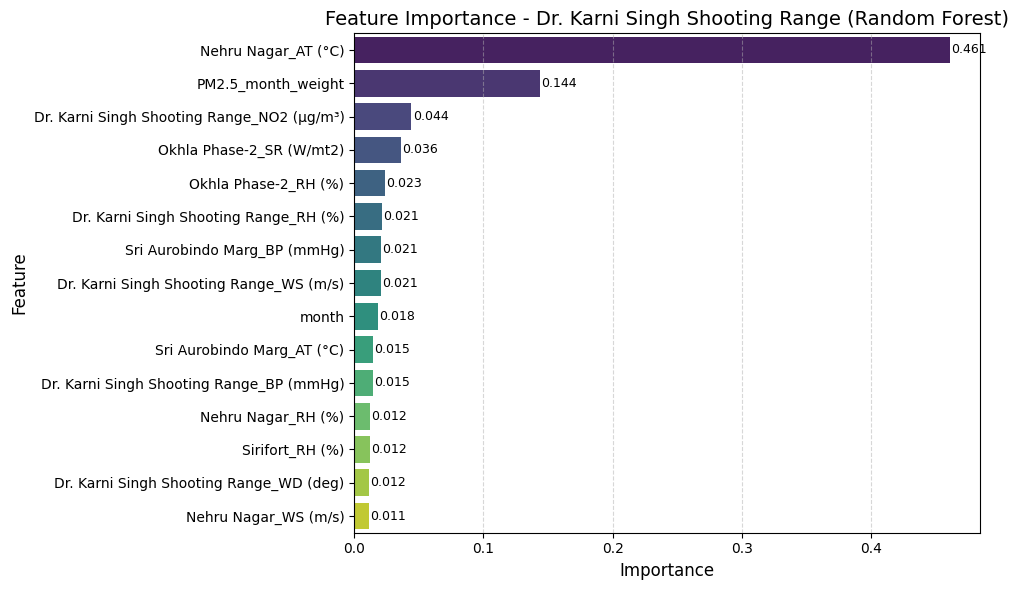

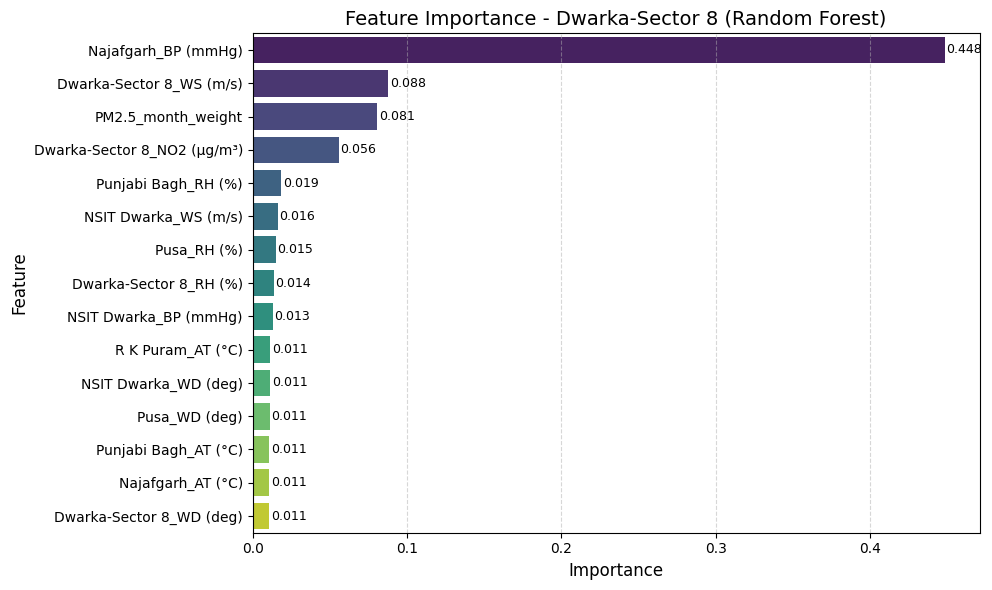

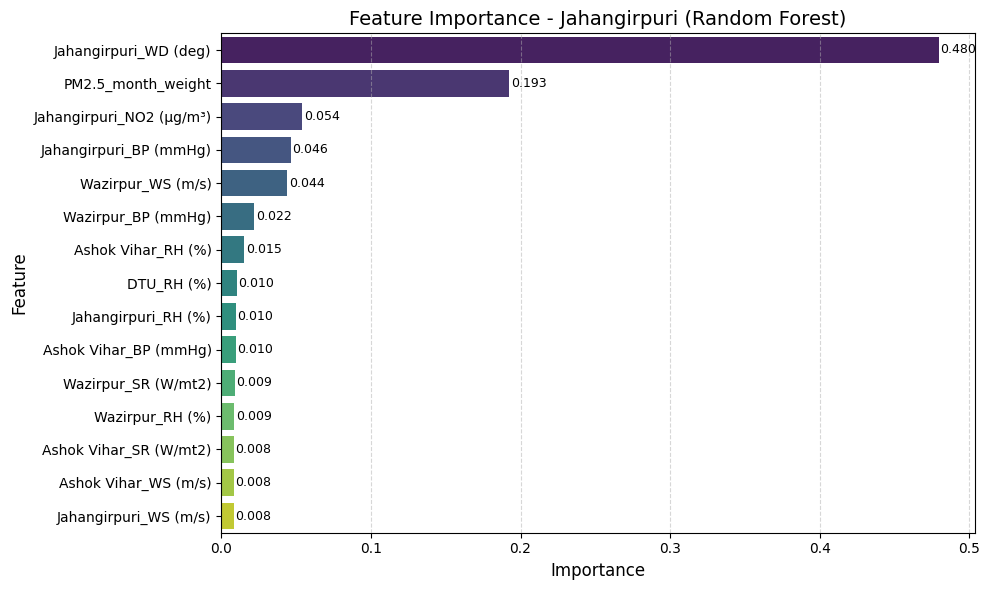

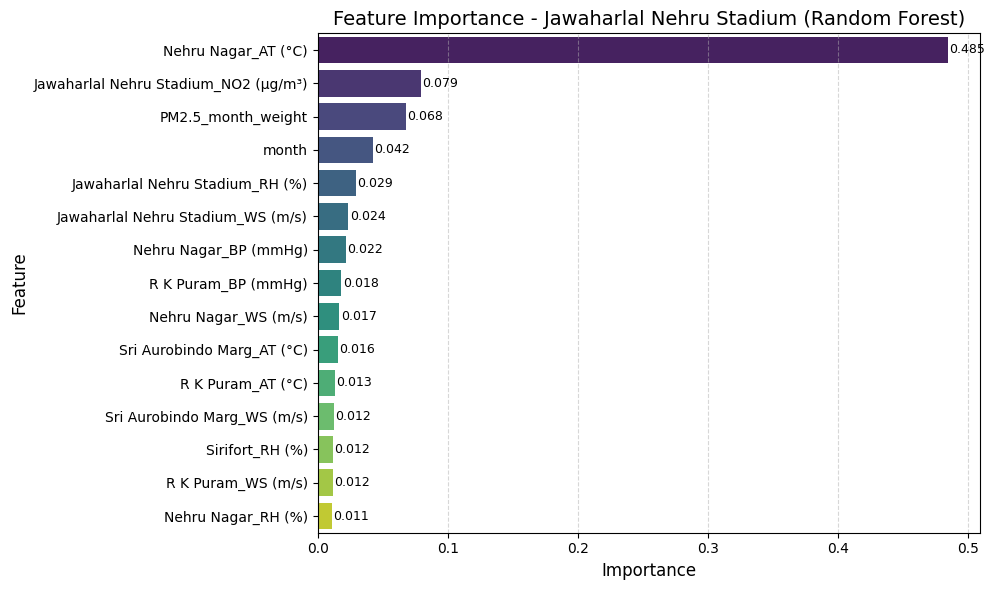

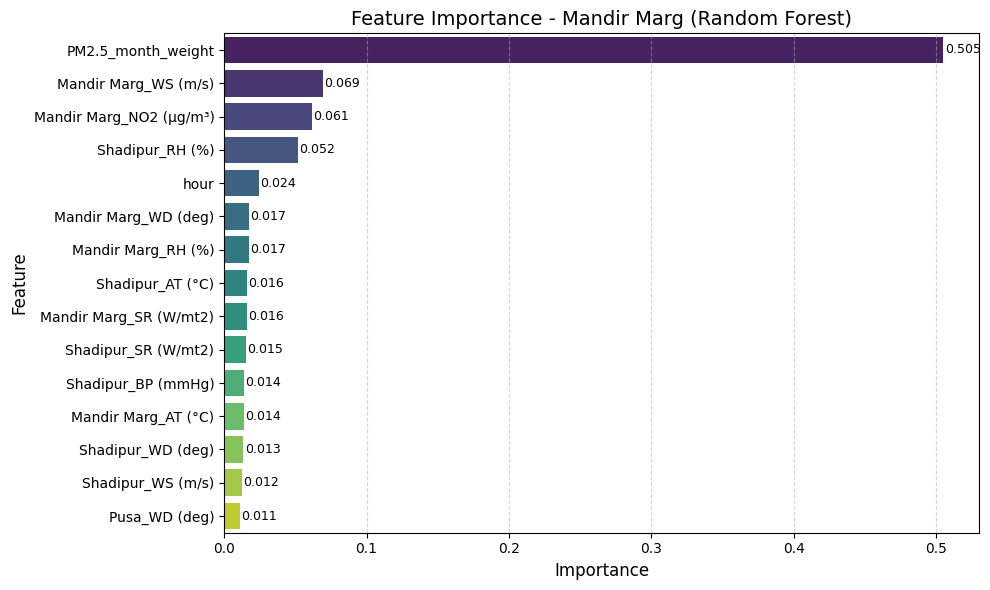

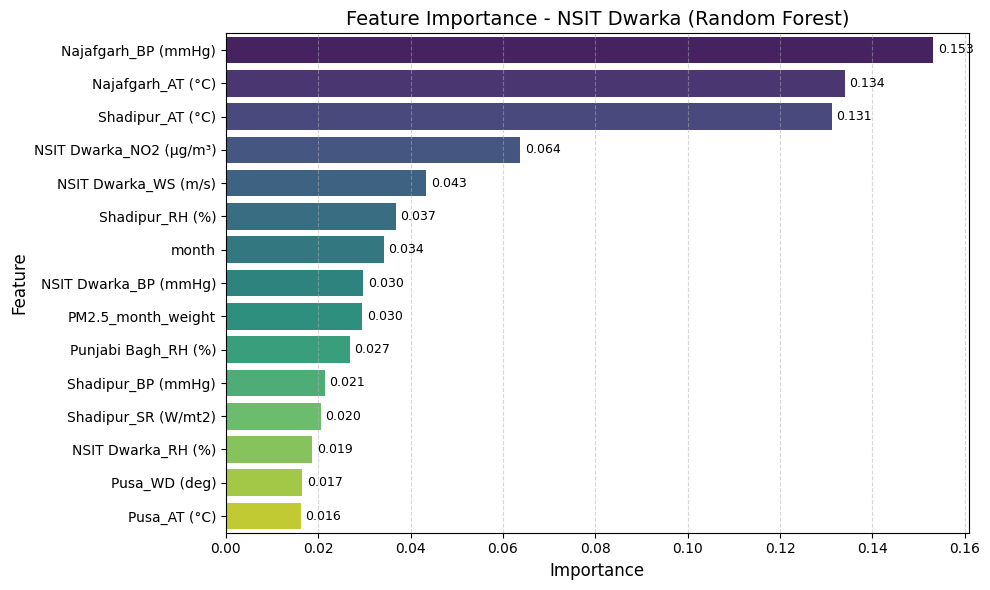

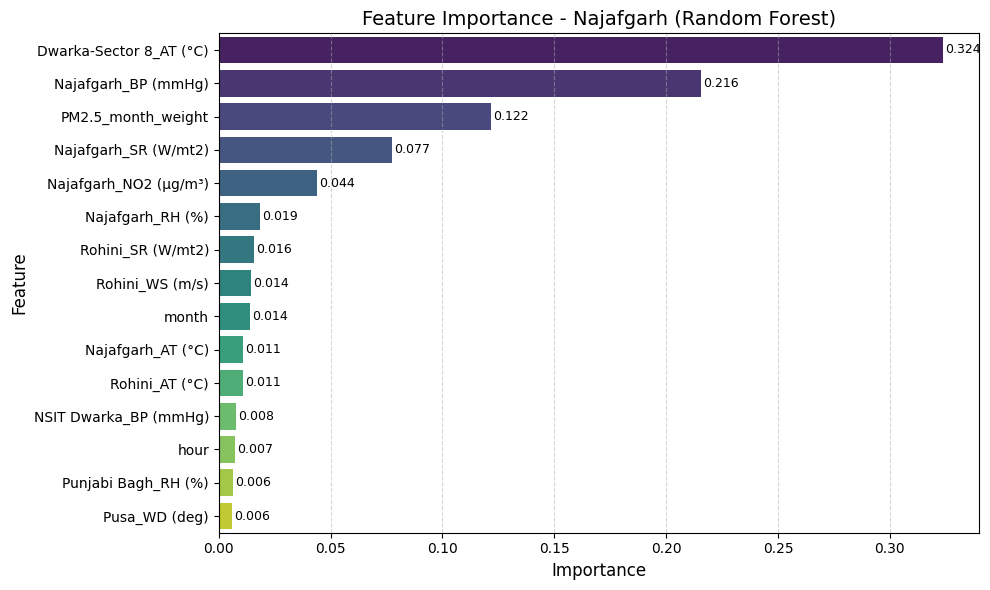

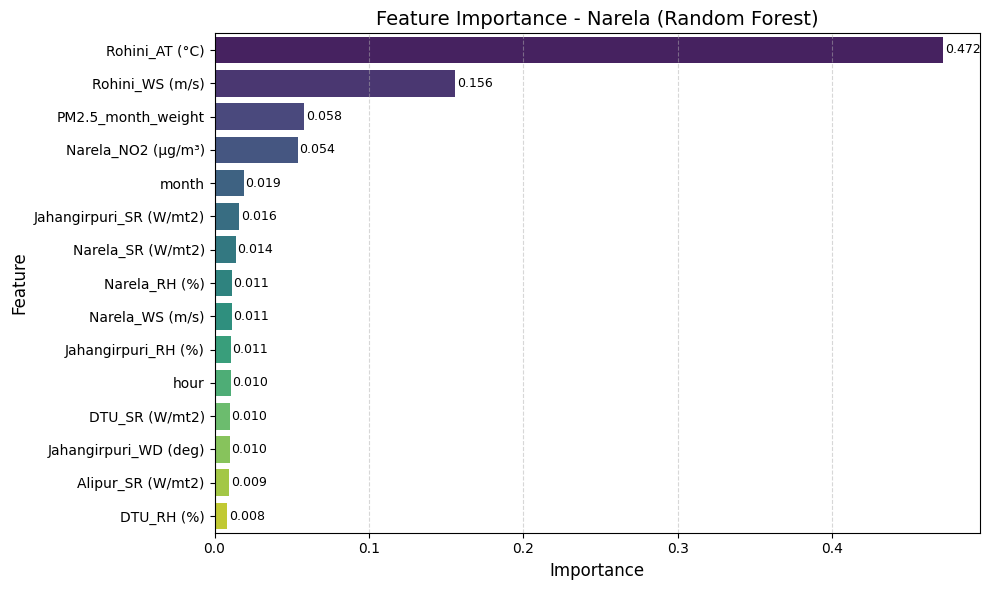

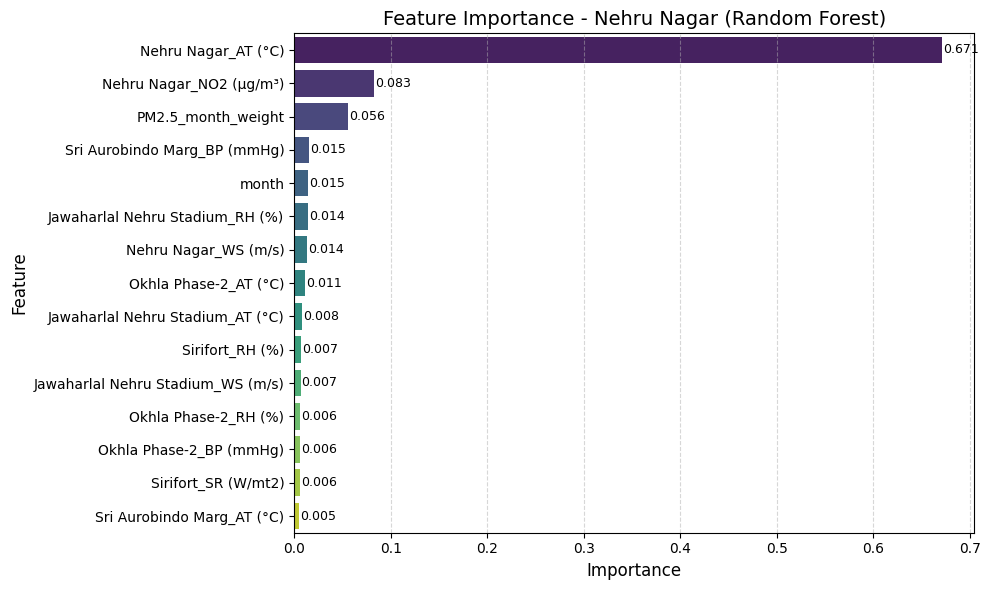

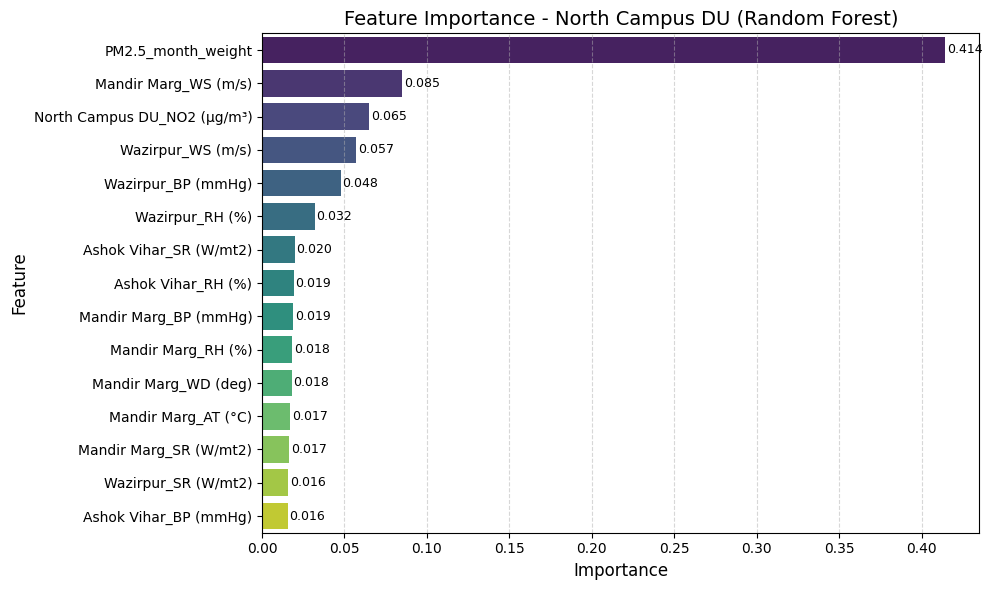

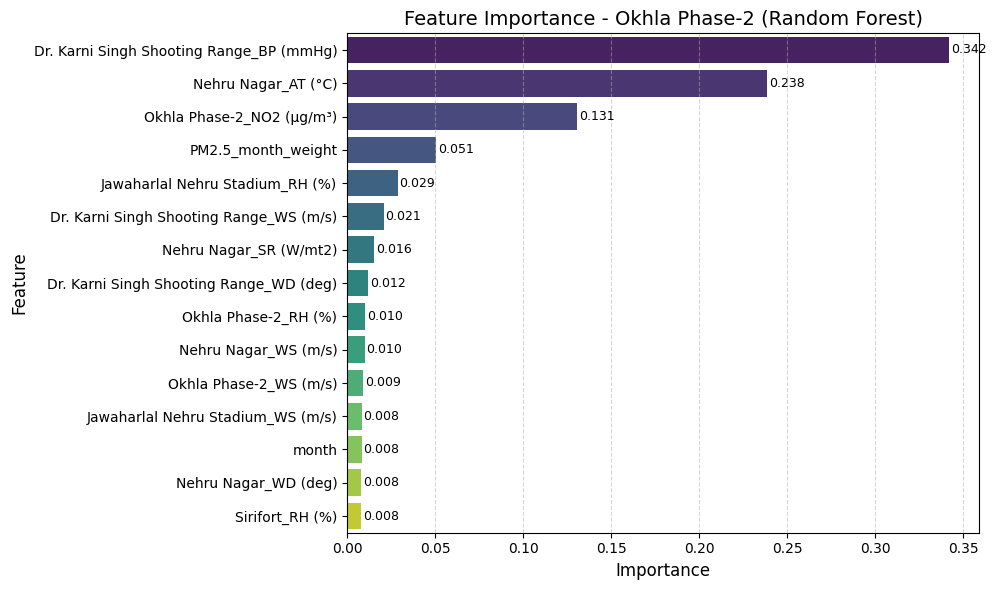

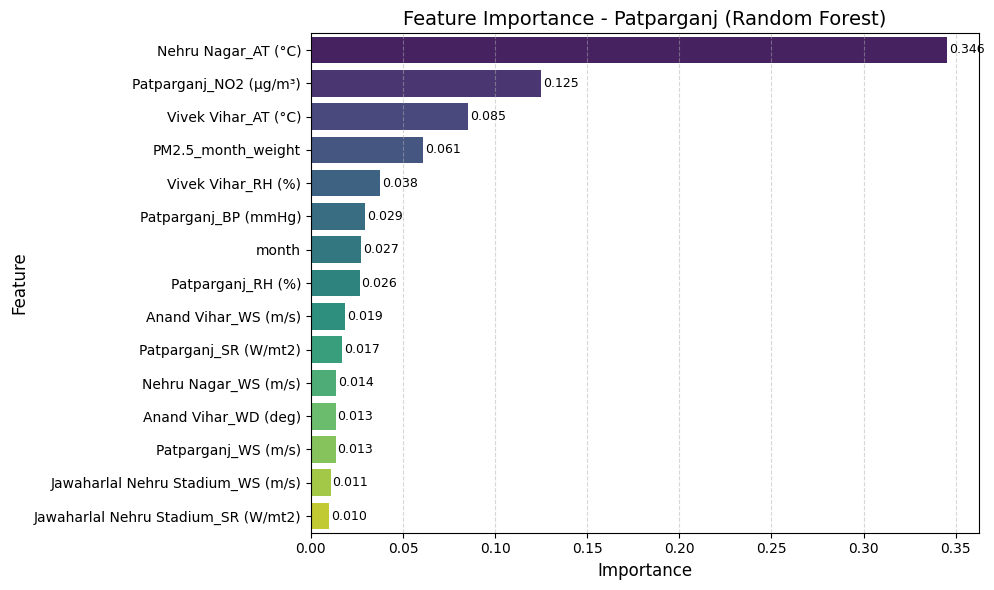

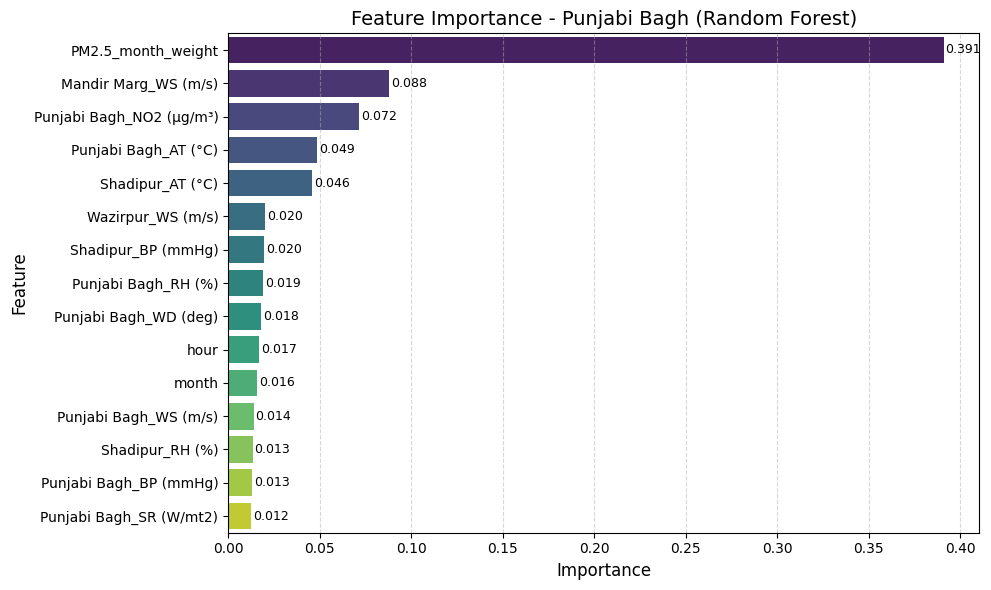

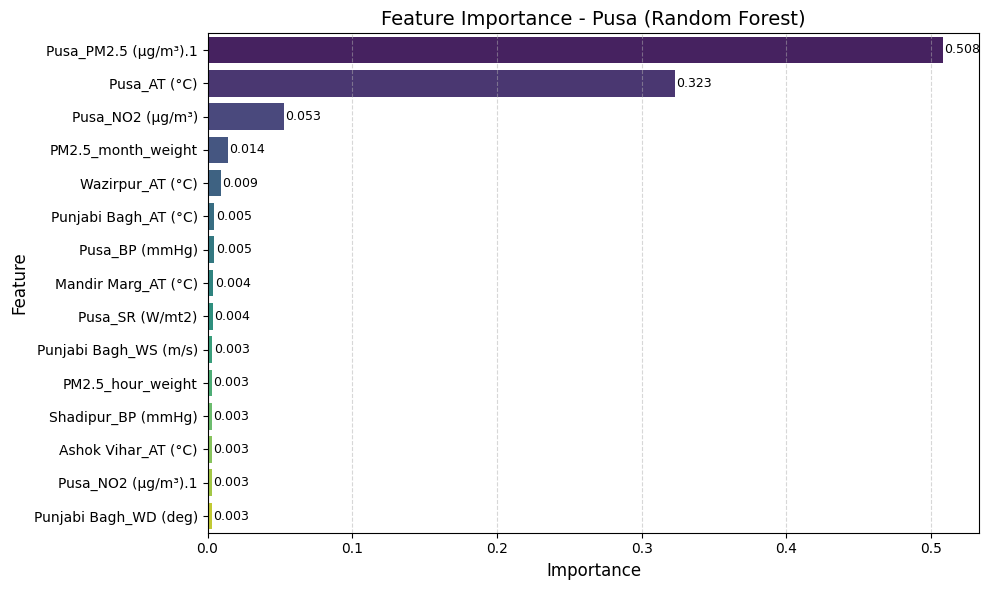

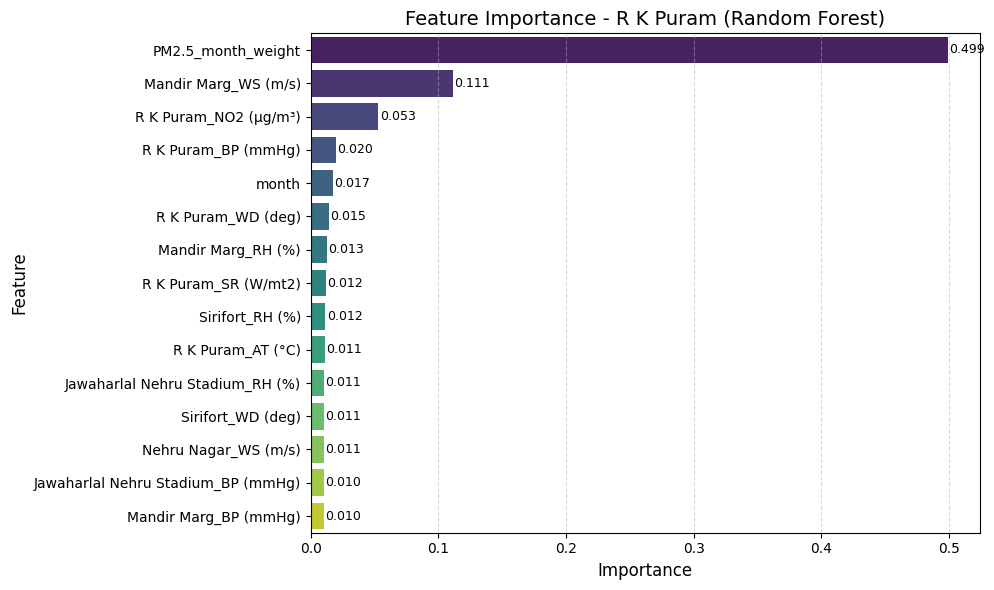

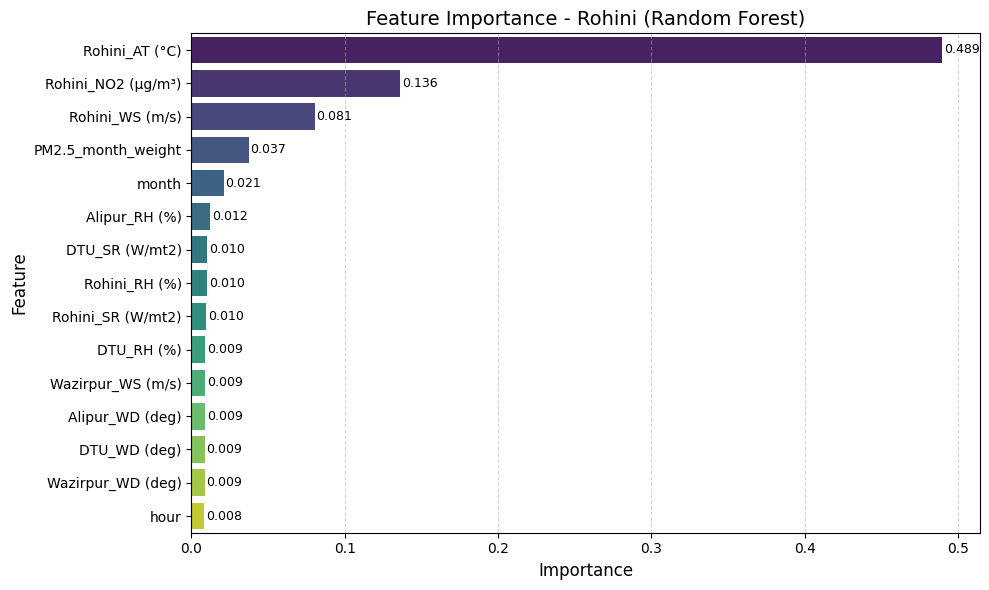

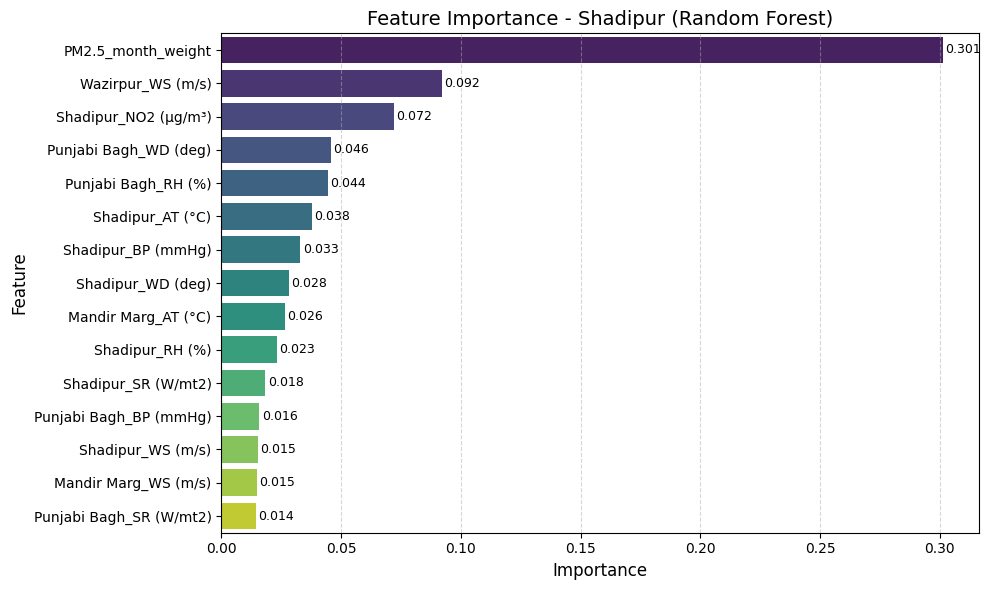

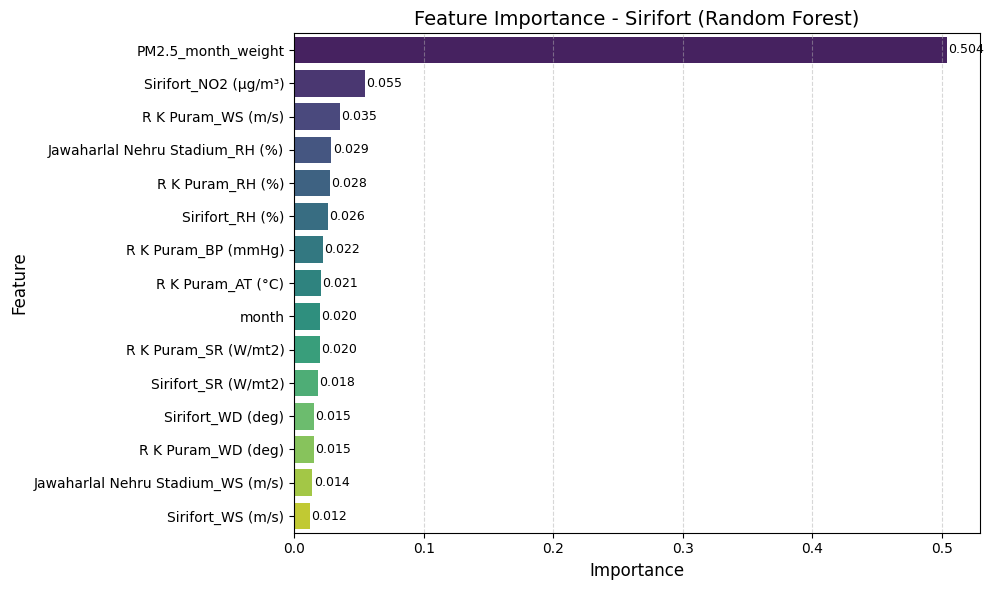

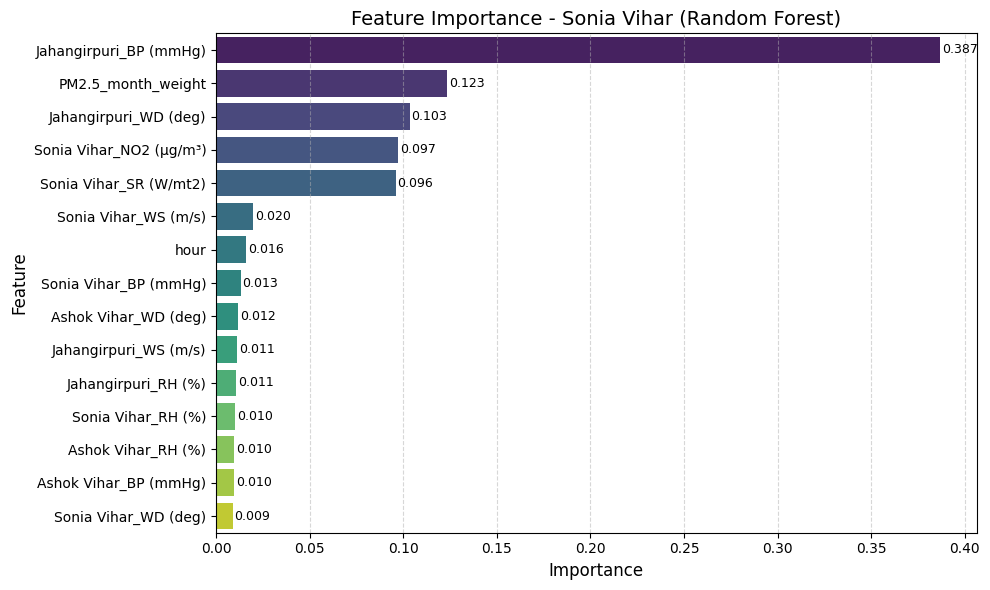

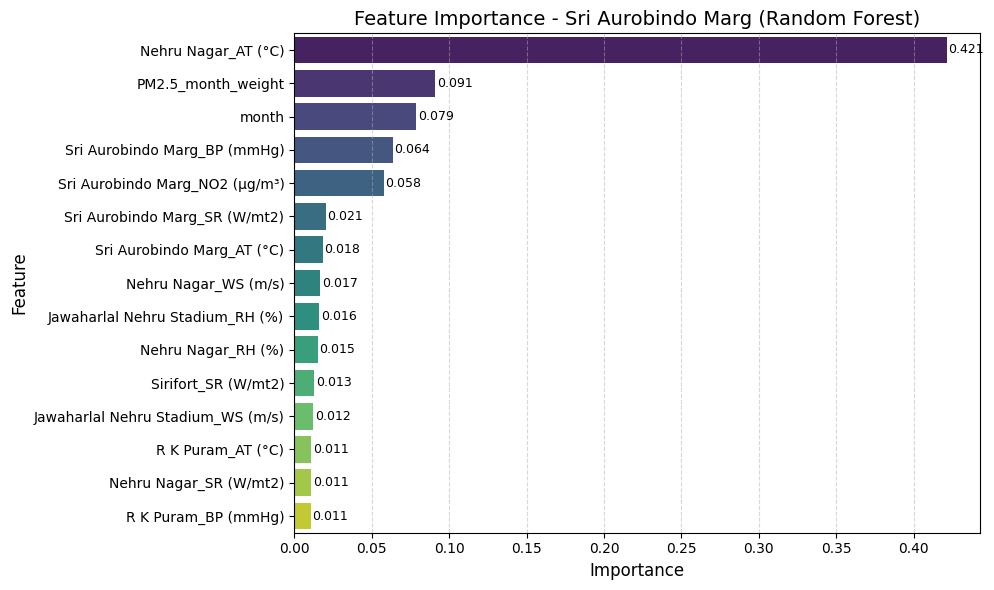

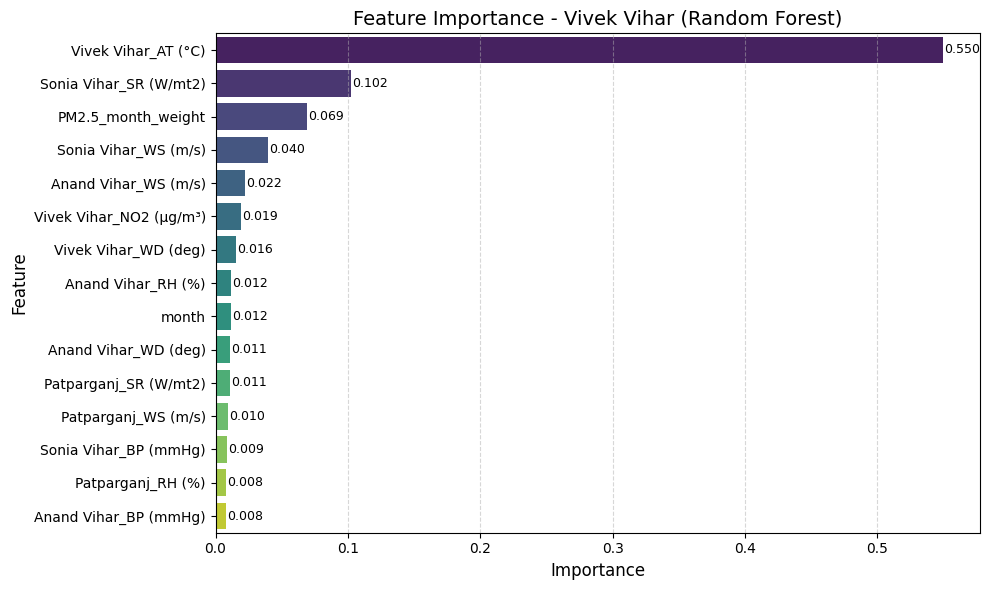

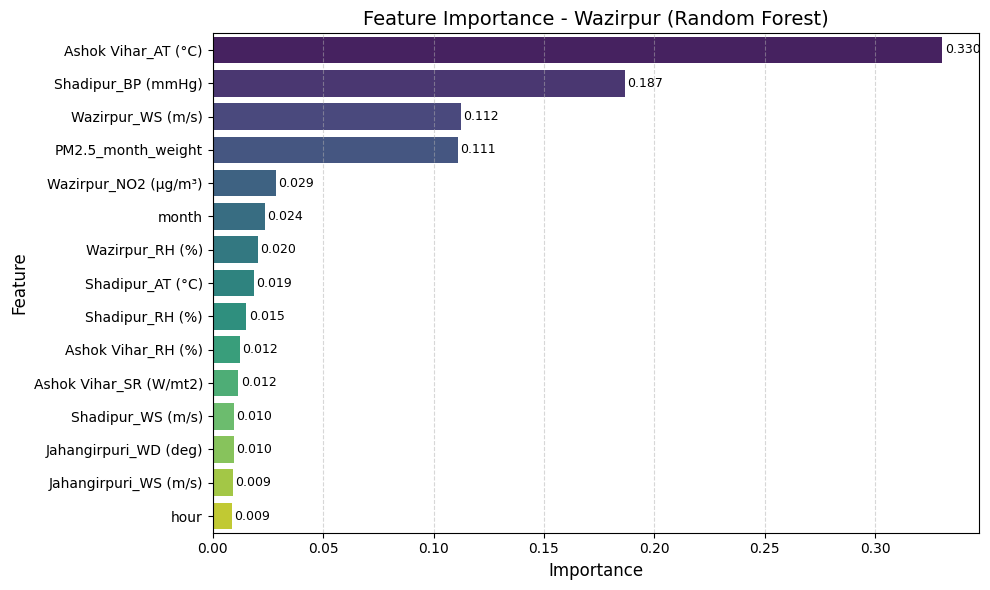

In [ ]:
# Assumes fi_df is already created and available
# Filter only Random Forest feature importances
rf_importance_df = fi_df[fi_df['Model'] == 'Random Forest']

# Get unique stations
stations = rf_importance_df['Station'].unique()
for station in sorted(stations):
    station_df = rf_importance_df[rf_importance_df['Station'] == station].copy()
    station_df = station_df.sort_values(by='Importance', ascending=False)

    if station_df.empty or station_df['Importance'].sum() == 0:
        print(f"Skipping {station} - no significant features.")
        continue

    # Take top 15 features only for readability
    station_df = station_df.head(15).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=station_df, x='Importance', y='Feature', palette='viridis')

    plt.title(f'Feature Importance - {station} (Random Forest)', fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)

    # Add importance values on bars
    for i, (imp, feat) in enumerate(zip(station_df['Importance'], station_df['Feature'])):
        plt.text(imp + 0.001, i, f"{imp:.3f}", va='center', fontsize=9)

    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()


In [ ]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.73.0-cp311-cp311-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cach

Deep Learning Model 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt


In [ ]:


# Define the target station
station = "Pusa"
target_col = f"{station}_PM2.5 (µg/m³)"

# Check if column exists
if target_col not in df.columns:
    print(f"Skipping {station} - column not found")
else:
    # Get RF-selected important features for the station
    rf_feats = fi_df[(fi_df['Station'] == station) &
                     (fi_df['Model'] == 'Random Forest') &
                     (fi_df['Importance'] > 0)]

    important_feats = rf_feats['Feature'].tolist()

    if not important_feats:
        print(f"No important features found for {station}")
    else:
        # Prepare the data
        df_station = df[['Timestamp', target_col] + important_feats].dropna().sort_values('Timestamp')
        X = df_station.drop(columns=['Timestamp', target_col])
        y = df_station[target_col]

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Train-test split
        train_mask = df_station['Timestamp'] < '2024-01-01'
        test_mask = df_station['Timestamp'] >= '2024-01-01'
        X_train, y_train = X_scaled[train_mask], y[train_mask]
        X_test, y_test = X_scaled[test_mask], y[test_mask]

        # Define ANN model
        ann = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        ann.compile(optimizer='adam', loss='mse')

        # Train ANN
        ann.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

        # Predict and evaluate
        y_pred = ann.predict(X_test).flatten()
        r2 = r2_score(y_test, y_pred)

        print(f"{station} - ANN R² Score: {r2:.4f}")


Epoch 1/30


c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6079.1221
Epoch 2/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 674.3096
Epoch 3/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 518.9652
Epoch 4/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 445.1195
Epoch 5/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 437.4337
Epoch 6/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 444.5887
Epoch 7/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 398.2453
Epoch 8/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 409.9365
Epoch 9/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 415.8901
Epoch 10/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 385.9525
Epoch 11/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 387.0926
Epoch 12/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 380.8395
Epoch 13/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 379.1028
Epoch 14/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 370.4438
Epoch 15/30
320/320 ━━━━━━━━━━━━━━━━━━━

[ℹ️] Using 45 important features for station: Pusa
[✔️] Training samples: 10224, Testing samples: 1176


c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5149.8120 - val_loss: 2061.1902
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 632.8483 - val_loss: 1435.7556
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 485.6713 - val_loss: 1389.1320
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 494.2311 - val_loss: 1344.5720
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 459.7199 - val_loss: 1278.4177
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 431.1607 - val_loss: 1360.6508
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 444.6582 - val_loss: 1212.7278
Epoch 8/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 448.9202 - val_loss: 1152.6790
Epoch 9/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 454.8654 - val_loss: 1271.5016
Epoch 10/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 425.3929 - val_loss: 1179.4386
Epoch 11/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 448.1168 - val_loss: 1303.7

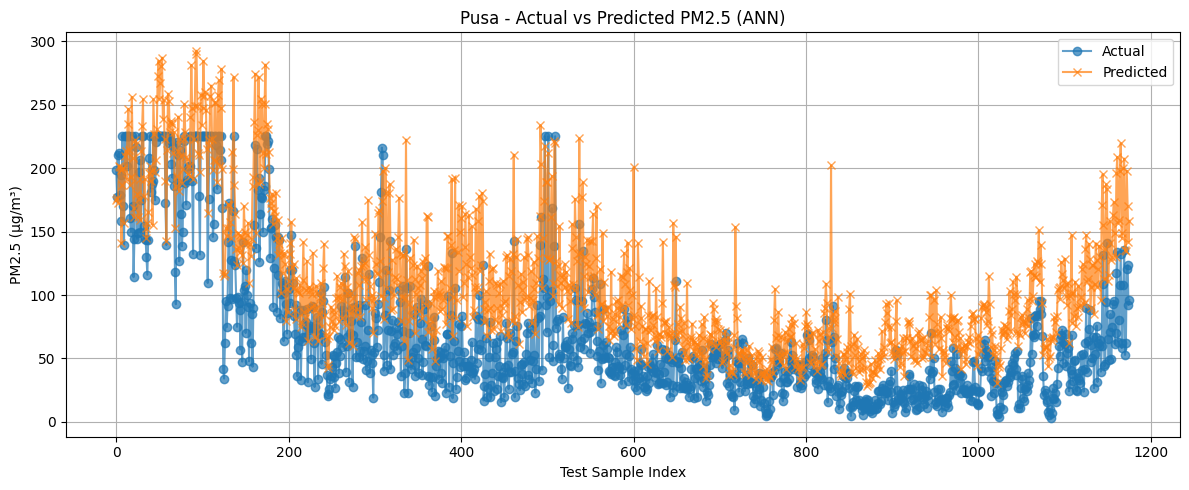

C:\Users\jains\AppData\Local\Temp\ipykernel_13008\1724055161.py:82: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




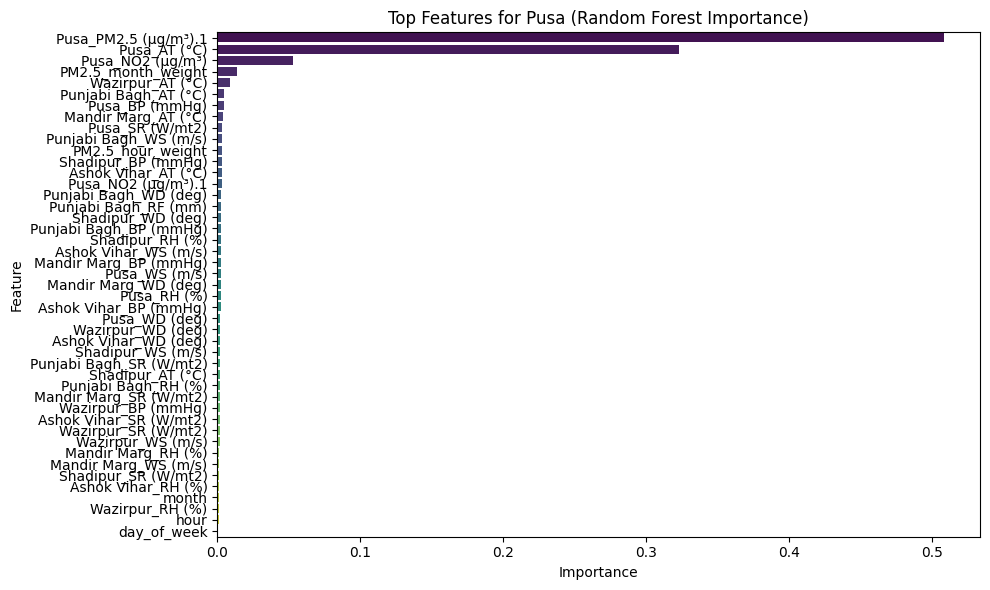

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Set station
station = "Pusa"
target_col = f"{station}_PM2.5 (µg/m³)"

# Check if data column is present
if target_col not in df.columns:
    print(f"[❌] Skipping {station} - Target column not found in dataset.")
else:
    # Get features selected from Random Forest
    rf_feats = fi_df[(fi_df['Station'] == station) &
                     (fi_df['Model'] == 'Random Forest') &
                     (fi_df['Importance'] > 0)]

    important_feats = rf_feats['Feature'].tolist()

    if not important_feats:
        print(f"[❌] No important features found for {station}")
    else:
        print(f"[ℹ️] Using {len(important_feats)} important features for station: {station}")
        
        # Filter relevant data
        df_station = df[['Timestamp', target_col] + important_feats].dropna().sort_values('Timestamp')
        X = df_station.drop(columns=['Timestamp', target_col])
        y = df_station[target_col]

        # Standardize X
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Time-based train-test split
        train_mask = df_station['Timestamp'] < '2024-01-01'
        test_mask = df_station['Timestamp'] >= '2024-01-01'
        X_train, y_train = X_scaled[train_mask], y[train_mask]
        X_test, y_test = X_scaled[test_mask], y[test_mask]

        print(f"[✔️] Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

        # Build ANN model
        ann = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        ann.compile(optimizer='adam', loss='mse')

        # Train ANN
        history = ann.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, validation_split=0.1)

        # Predict and evaluate
        y_pred = ann.predict(X_test).flatten()
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        print(f"\n[📈] ANN Performance for {station}")
        print(f"R² Score: {r2:.4f}")
        print(f"Mean Squared Error: {mse:.2f}")

        # Plot prediction vs actual
        plt.figure(figsize=(12, 5))
        plt.plot(y_test.values, label='Actual', marker='o', alpha=0.7)
        plt.plot(y_pred, label='Predicted', marker='x', alpha=0.7)
        plt.title(f"{station} - Actual vs Predicted PM2.5 (ANN)")
        plt.xlabel("Test Sample Index")
        plt.ylabel("PM2.5 (µg/m³)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot RF feature importance used
        plt.figure(figsize=(10, 6))
        sns.barplot(data=rf_feats.sort_values(by="Importance", ascending=False),
                    x="Importance", y="Feature", palette="viridis")
        plt.title(f"Top Features for {station} (Random Forest Importance)")
        plt.tight_layout()
        plt.show()


Running for station: Pusa
Preparing data without feature importance...


c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
R² without feature importance: 0.8212
Preparing data with Random Forest feature importance...


c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
R² with feature importance: 0.7041

--- Final R² Comparison ---
Without Feature Importance: R² = 0.8212
With Feature Importance: R² = 0.7041


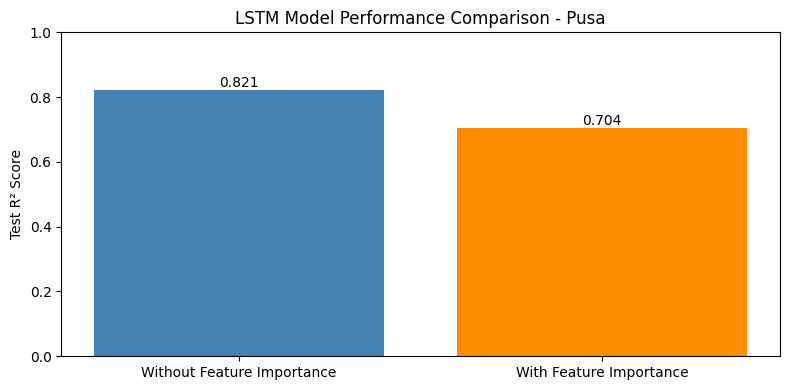

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Parameters
station = "Pusa"
target_col = f"{station}_PM2.5 (µg/m³)"
time_steps = 24

# Helper function to create sliding windows
def create_lstm_dataset(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

results = {}

if target_col in df.columns:
    print(f"Running for station: {station}")
    
    # --- WITHOUT Feature Importance ---
    print("Preparing data without feature importance...")
    df_no_fi = df.dropna(subset=[target_col]).sort_values('Timestamp')
    base_features = [col for col in df.columns if col not in ['Timestamp', target_col] and col.endswith('(µg/m³)')]

    df_base = df_no_fi[['Timestamp', target_col] + base_features].dropna()

    # Split using timestamp
    train_df_base = df_base[df_base['Timestamp'] < '2024-01-01']
    test_df_base = df_base[df_base['Timestamp'] >= '2024-01-01']

    # Features and targets
    X_train_base = train_df_base.drop(columns=['Timestamp', target_col])
    y_train_base = train_df_base[target_col]
    X_test_base = test_df_base.drop(columns=['Timestamp', target_col])
    y_test_base = test_df_base[target_col]

    # Scale
    scaler_base = StandardScaler()
    X_train_base_scaled = scaler_base.fit_transform(X_train_base)
    X_test_base_scaled = scaler_base.transform(X_test_base)

    # LSTM dataset
    X_train_lstm_base, y_train_lstm_base = create_lstm_dataset(X_train_base_scaled, y_train_base.to_numpy(), time_steps)
    X_test_lstm_base, y_test_lstm_base = create_lstm_dataset(X_test_base_scaled, y_test_base.to_numpy(), time_steps)

    # Model
    lstm_base = Sequential([
        LSTM(64, input_shape=(X_train_lstm_base.shape[1], X_train_lstm_base.shape[2]), return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    lstm_base.compile(optimizer=Adam(), loss='mse')
    lstm_base.fit(X_train_lstm_base, y_train_lstm_base, epochs=20, batch_size=32, verbose=0)

    # Evaluate
    y_pred_base = lstm_base.predict(X_test_lstm_base).flatten()
    r2_base = r2_score(y_test_lstm_base, y_pred_base)
    results['Without Feature Importance'] = r2_base
    print(f"R² without feature importance: {r2_base:.4f}")

    # --- WITH Feature Importance ---
    print("Preparing data with Random Forest feature importance...")
    rf_feats = fi_df[(fi_df['Station'] == station) & 
                     (fi_df['Model'] == 'Random Forest') & 
                     (fi_df['Importance'] > 0)]

    important_feats = rf_feats['Feature'].tolist()

    if important_feats:
        df_fi = df[['Timestamp', target_col] + important_feats].dropna().sort_values('Timestamp')

        train_df_fi = df_fi[df_fi['Timestamp'] < '2024-01-01']
        test_df_fi = df_fi[df_fi['Timestamp'] >= '2024-01-01']

        X_train_fi = train_df_fi.drop(columns=['Timestamp', target_col])
        y_train_fi = train_df_fi[target_col]
        X_test_fi = test_df_fi.drop(columns=['Timestamp', target_col])
        y_test_fi = test_df_fi[target_col]

        scaler_fi = StandardScaler()
        X_train_fi_scaled = scaler_fi.fit_transform(X_train_fi)
        X_test_fi_scaled = scaler_fi.transform(X_test_fi)

        X_train_lstm_fi, y_train_lstm_fi = create_lstm_dataset(X_train_fi_scaled, y_train_fi.to_numpy(), time_steps)
        X_test_lstm_fi, y_test_lstm_fi = create_lstm_dataset(X_test_fi_scaled, y_test_fi.to_numpy(), time_steps)

        lstm_fi = Sequential([
            LSTM(64, input_shape=(X_train_lstm_fi.shape[1], X_train_lstm_fi.shape[2]), return_sequences=False),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        lstm_fi.compile(optimizer=Adam(), loss='mse')
        lstm_fi.fit(X_train_lstm_fi, y_train_lstm_fi, epochs=20, batch_size=32, verbose=0)

        y_pred_fi = lstm_fi.predict(X_test_lstm_fi).flatten()
        r2_fi = r2_score(y_test_lstm_fi, y_pred_fi)
        results['With Feature Importance'] = r2_fi
        print(f"R² with feature importance: {r2_fi:.4f}")
    else:
        print("No important features found for this station. Skipping RF-based feature model.")

# --- Final Comparison ---
print("\n--- Final R² Comparison ---")
for method, r2_val in results.items():
    print(f"{method}: R² = {r2_val:.4f}")

# Optional: Bar Plot of Comparison
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values(), color=['steelblue', 'darkorange'])
plt.ylabel("Test R² Score")
plt.title(f"LSTM Model Performance Comparison - {station}")
plt.ylim(0, 1)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()
